# General variables and libraries
Run this cell first

In [1]:
import sys
import glob
sys.path.append(glob.glob('/home/*/Dropbox/TY_scripts/')[0])
from TY_stats import *
import os
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statannot import add_stat_annotation
import colorcet as cc
import matplotlib.patches as mpatches
from patsy import ModelDesc
from statsmodels.formula.api import ols

%matplotlib inline

sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .8 #adjust line width
plt.rcParams['figure.dpi'] = 200 #dpi in notebook
plt.rcParams['savefig.dpi'] = 600 #dpi in saved figure

#VARIABLES
BIG = '/home/meco/Big_data/RUSITEC/16S_2020'
TABS = 'Data/Tables/'
META = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
DOMS = ['Archaea', 'Bacteria']

ALPHAS = {
    'shannon': 'Shannon entropy', 
    #'observed_features': 'Observed features',
    #'evenness': 'Pielou\'s evenness',
    'faith_pd': 'Faith\'s PD'}

STYPES = {
    'RSP': 'RSP', 
    'RF': 'RF',
    #'E': 'Effluent',
    'FL': 'Fermenter liquid', 
    'FR': 'Feed residue'}

BETAS = {
    #'aitchison': 'Aitchison', 
    'bray_curtis': 'Bray-Curtis'}

MDICT = {
    'RF': 'd', 
    'RSP': 's', 
    #'E': '^', 
    'FL': 'p', 
    'FR': 'X'}

CDICT = {'TMR': 'grey',
         'AN1': 'limegreen',
         'AN2': 'green',
         'AT': 'red',
         'FV1': 'deepskyblue',
         'FV2': 'blue',
         'NoT': 'whitesmoke'}

# Install dependencies

In [4]:
!pip install deicode
!qiime dev refresh-cache

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.


In [5]:
!conda install -y -c conda-forge statannot

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



## Package Plan ##

  environment location: /home/meco/anaconda3/envs/qiime2-2023.5

  added / updated specs:
    - statannot


The following NEW packages will be INSTALLED:

  statannot          conda-forge/noarch::statannot-0.2.3-pyhd8ed1ab_0 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [6]:
!pip install colorcet

  Using cached colorcet-3.0.1-py2.py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 5.3 MB/s eta 0:00:00


# Edit metadata file

In [24]:
names = {
    'Trt1': 'TMR',
    'Trt2': 'AN1',
    'Trt3': 'AN2',
    'Trt4': 'AT',
    'Trt5': 'FV1',
    'Trt6': 'FV2',
    'not_appl':'NoT'}

#META['Trt'] = META.Treatment.map(names)
META['sType'] = META.BS.str.replace('E', 'FL')
META.to_csv('metadata.tsv', sep='\t')

# Barcode file

In [8]:
# read tables to create a metadata
bc = pd.read_csv('Descriptions/Barcodes.tsv',sep='\t')

# add domain info to SampleID
mixed = ['pooled #1-3','pooled #4-6','pooled #80-82','pooled #83-85']
for mix in mixed: # edit pooled sample names
    bc.loc[bc['SampleID']==mix, 'SampleID']='mix' + mix.split('#')[-1]
bc.set_index('SampleID', inplace=True)

# Replace failed samples with new ones
repl = pd.read_csv('Descriptions/Replacement.tsv', sep='\t')
mixed = ['pooled #1-3', 'pooled #4-6', 'pooled #80-82', 'pooled #83-85']
for mix in mixed:
    repl.loc[repl['Smpl_no']==mix, 'Smpl_no'] = 'mix' + mix.split('#')[-1]
repl['SampleID'] = repl['Smpl_no'].str.split('_').str[0] + 's'
repl.set_index('SampleID', inplace=True)
for index in repl.index:
    bc.loc[index, 'BC'] = repl.loc[index,'Barcode']
    bc.loc[index, 'Run_Ind'] = 'r3_i12'
    
display(bc)
bc.to_csv('barcodes.tsv', sep='\t') # save barcodes

,Sample INFO,Primers,Barcode,Index,BC,Run,Run_Ind
SampleID,,,,,,,
1b,Rumen solid phase from day 0 (start),V1-2,BC1,Index 1,AAGCCT,1,r1_i1
2b,Rumen solid phase from day 0 (start),V1-2,BC2,Index 1,AAGTTA,1,r1_i1
3b,Rumen solid phase from day 0 (start),V1-2,BC3,Index 1,AATACG,1,r1_i1
4b,Rumen fluid from day 0 (start),V1-2,BC4,Index 1,AATCGA,1,r1_i1
5b,Rumen fluid from day 0 (start),V1-2,BC5,Index 1,AATGAT,1,r1_i1
...,...,...,...,...,...,...,...
158a,Effluent at day 13,Arch,AFor39,Index 5,TAGAAT,2,r3_i12
mix1-3a,NaN,Arch,AFor40,Index 5,TATTAC,2,r3_i12
mix4-6a,NaN,Arch,AFor41,Index 5,TCCTAA,2,r3_i12


# Demultiplex with Sabre

In [12]:
!conda install -y -c bioconda sabre

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



## Package Plan ##

  environment location: /home/meco/anaconda3/envs/qiime2-2023.5

  added / updated specs:
    - sabre


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.05.30 |       h06a4308_0         120 KB
    certifi-2023.5.7           |   py38h06a4308_0         152 KB
    sabre-1.000                |       he4a0461_5          20 KB  bioconda
    ------------------------------------------------------------
                                           Total:         291 KB

The following NEW packages will be INSTALLED:

  sabre              bioconda/linux

In [2]:
met = pd.read_csv('barcodes.tsv', sep='\t', index_col='SampleID',
                  usecols=['SampleID', 'BC', 'Run_Ind'])

for ri in os.listdir(f'{BIG}/Raw_reads'):
    out = f"{BIG}/Demultiplexed/Reads-{ri.split('_')[0] +'_'+ ri.split('_')[-1]}/"
    !mkdir -p $out
    meta = met.loc[met.Run_Ind == ri.rsplit('_', 1)[0]].copy()
    meta['r1'] = out + meta.index +'_'+ meta.BC +'_L001_R1_001.fastq'
    meta['r2'] = out + meta.index +'_'+ meta.BC +'_L001_R2_001.fastq'
    meta.set_index('BC', inplace=True)
    meta.drop('Run_Ind', axis=1, inplace=True)
    bc = f'{out}/bc.txt'
    meta.to_csv(bc, sep='\t', header=False)
    f = f'{BIG}/Raw_reads/{ri}/forward.fastq.gz'
    r = f'{BIG}/Raw_reads/{ri}/reverse.fastq.gz'
    u = f'{BIG}/no_bc_match_{ri}_R1.fastq'
    w = f'{BIG}/no_bc_match_{ri}_R2.fastq'
    
    !sabre pe -m 0 -f $f -r $r -b $bc -u $u -w $w
    !rm $bc
    !pigz $out/*.fastq #faster alternative to gzip!
!rm $BIG/Demultiplexed/Reads-*/no_bc_match*


Total FastQ records: 963028 (481514 pairs)

FastQ records for barcode AATACG: 20050 (10025 pairs)
FastQ records for barcode AAGTTA: 15088 (7544 pairs)
FastQ records for barcode AAGCCT: 20084 (10042 pairs)
FastQ records for barcode TTATGC: 19684 (9842 pairs)
FastQ records for barcode TGGTCC: 19596 (9798 pairs)
FastQ records for barcode TCTGCC: 21532 (10766 pairs)
FastQ records for barcode TCTAGT: 19236 (9618 pairs)
FastQ records for barcode TCGCCG: 24000 (12000 pairs)
FastQ records for barcode TCCGAG: 23852 (11926 pairs)
FastQ records for barcode TCATAA: 21664 (10832 pairs)
FastQ records for barcode TATCTC: 21564 (10782 pairs)
FastQ records for barcode TACTTG: 18530 (9265 pairs)
FastQ records for barcode TACGGT: 19324 (9662 pairs)
FastQ records for barcode GTCTCT: 21214 (10607 pairs)
FastQ records for barcode GTCAAG: 18618 (9309 pairs)
FastQ records for barcode GTACGT: 19292 (9646 pairs)
FastQ records for barcode GTAATC: 20740 (10370 pairs)
FastQ records for barcode GGTACC: 20196 (1009

# Import to Qiime2

In [2]:
!mkdir -p $BIG/Demux Data/Demux

for run in os.listdir(f'{BIG}/Demultiplexed'):
    demux = f'{BIG}/Demux/{run}_demux.qza'
    deqzv = f'Data/Demux/{run}_demux.qzv'
    
    !qiime tools import \
        --type 'SampleData[PairedEndSequencesWithQuality]' \
        --input-path $BIG/Demultiplexed/$run \
        --input-format CasavaOneEightSingleLanePerSampleDirFmt \
        --output-path $demux
    
    !qiime demux summarize \
        --i-data $demux \
        --o-visualization $deqzv

Imported /home/meco/Big_data/RUSITEC/16S_2020/Demultiplexed/Reads-r2_L1 as CasavaOneEightSingleLanePerSampleDirFmt to /home/meco/Big_data/RUSITEC/16S_2020/Demux/Reads-r2_L1_demux.qza
Saved Visualization to: Data/Demux/Reads-r2_L1_demux.qzv
Imported /home/meco/Big_data/RUSITEC/16S_2020/Demultiplexed/Reads-r3_L2 as CasavaOneEightSingleLanePerSampleDirFmt to /home/meco/Big_data/RUSITEC/16S_2020/Demux/Reads-r3_L2_demux.qza
Saved Visualization to: Data/Demux/Reads-r3_L2_demux.qzv
Imported /home/meco/Big_data/RUSITEC/16S_2020/Demultiplexed/Reads-r1_L2 as CasavaOneEightSingleLanePerSampleDirFmt to /home/meco/Big_data/RUSITEC/16S_2020/Demux/Reads-r1_L2_demux.qza
Saved Visualization to: Data/Demux/Reads-r1_L2_demux.qzv
Imported /home/meco/Big_data/RUSITEC/16S_2020/Demultiplexed/Reads-r1_L1 as CasavaOneEightSingleLanePerSampleDirFmt to /home/meco/Big_data/RUSITEC/16S_2020/Demux/Reads-r1_L1_demux.qza
Saved Visualization to: Data/Demux/Reads-r1_L1_demux.qzv


# Cutadapt

In [3]:
!mkdir -p $BIG/Cutadapt Data/Cutadapt

for dem in os.listdir(f'{BIG}/Demux'):
    run = dem.split('-')[-1].split('_dem')[0]
    demux = f'{BIG}/Demux/' + dem
    cutad = f'{BIG}/Cutadapt/{run}_trim.qza'
    cuqzv = f'Data/Cutadapt/{run}_trim.qzv'
    forwd = 'GYGCASCAGKCGMGAA'
    revrs = 'GGACTACVSGGGTATCTAAT'
    
    if 'r1' in run:
        forwd = 'CAAGRGTTHGATYMTGGCTCAG'
        revrs ='TGCTGCCTCCCGTAGGAGT'
    
    !qiime cutadapt trim-paired \
        --i-demultiplexed-sequences $demux \
        --o-trimmed-sequences $cutad \
        --p-cores 6 \
        --p-front-f $forwd \
        --p-front-r $revrs \
        --p-match-adapter-wildcards \
        --p-discard-untrimmed \
        --p-match-read-wildcards

    !qiime demux summarize \
            --i-data $cutad \
            --o-visualization $cuqzv
    
!rm -r $BIG/Demux

Saved SampleData[PairedEndSequencesWithQuality] to: /home/meco/Big_data/RUSITEC/16S_2020/Cutadapt/r1_L2_trim.qza
Saved Visualization to: Data/Cutadapt/r1_L2_trim.qzv
Saved SampleData[PairedEndSequencesWithQuality] to: /home/meco/Big_data/RUSITEC/16S_2020/Cutadapt/r3_L2_trim.qza
Saved Visualization to: Data/Cutadapt/r3_L2_trim.qzv
Saved SampleData[PairedEndSequencesWithQuality] to: /home/meco/Big_data/RUSITEC/16S_2020/Cutadapt/r1_L1_trim.qza
Saved Visualization to: Data/Cutadapt/r1_L1_trim.qzv
Saved SampleData[PairedEndSequencesWithQuality] to: /home/meco/Big_data/RUSITEC/16S_2020/Cutadapt/r2_L1_trim.qza
Saved Visualization to: Data/Cutadapt/r2_L1_trim.qzv


# Dada2

In [4]:
!mkdir -p Data/Dada2

for cut in os.listdir(f'{BIG}/Cutadapt'):
    run = cut.split('_trim')[0]
    cutad = f'{BIG}/Cutadapt/{run}_trim.qza'
    table = f'Data/Dada2/{run}_table.qza'
    taqzv = f'Data/Dada2/{run}_table.qzv'
    repsq = f'Data/Dada2/{run}_rep-seqs.qza'
    reqzv = f'Data/Dada2/{run}_rep-seqs.qzv'
    stata = f'Data/Dada2/{run}_stats.qza'
    stqzv = f'Data/Dada2/{run}_stats.qzv'
    trimF = 215
    trimR = 210

    !qiime dada2 denoise-paired \
        --i-demultiplexed-seqs $cutad \
        --p-trunc-len-f $trimF \
        --p-trunc-len-r $trimR \
        --p-n-threads 0 \
        --o-table $table \
        --o-representative-sequences $repsq \
        --o-denoising-stats $stats

    !qiime feature-table tabulate-seqs \
        --i-data $repsq \
        --o-visualization $reqzv

    !qiime metadata tabulate \
        --m-input-file $stata \
        --o-visualization $stqzv

    !qiime feature-table summarize \
        --i-table $table \
        --o-visualization $taqzv
    
!rm -r $BIG/Cutadapt

Saved FeatureTable[Frequency] to: Data/Dada2/r3_L2_table.qza
Saved FeatureData[Sequence] to: Data/Dada2/r3_L2_rep-seqs.qza
Saved SampleData[DADA2Stats] to: Data/Dada2/r3_L2_stats.qza
Saved Visualization to: Data/Dada2/r3_L2_rep-seqs.qzv
Saved Visualization to: Data/Dada2/r3_L2_stats.qzv
Saved Visualization to: Data/Dada2/r3_L2_table.qzv
Saved FeatureTable[Frequency] to: Data/Dada2/r2_L1_table.qza
Saved FeatureData[Sequence] to: Data/Dada2/r2_L1_rep-seqs.qza
Saved SampleData[DADA2Stats] to: Data/Dada2/r2_L1_stats.qza
Saved Visualization to: Data/Dada2/r2_L1_rep-seqs.qzv
Saved Visualization to: Data/Dada2/r2_L1_stats.qzv
Saved Visualization to: Data/Dada2/r2_L1_table.qzv
Saved FeatureTable[Frequency] to: Data/Dada2/r1_L1_table.qza
Saved FeatureData[Sequence] to: Data/Dada2/r1_L1_rep-seqs.qza
Saved SampleData[DADA2Stats] to: Data/Dada2/r1_L1_stats.qza
Saved Visualization to: Data/Dada2/r1_L1_rep-seqs.qzv
Saved Visualization to: Data/Dada2/r1_L1_stats.qzv
Saved Visualization to: Data/Dada2

# Merge different runs

In [5]:
!mkdir -p $TABS

doms = {
    'Archaea': ['r2', 'r3'],
    'Bacteria': ['r1']}

d2 = 'Data/Dada2/'

for dom in doms:
    TABS = ' '.join([f'{d2}{t}' for t in os.listdir(d2) if t.split('_')[0] in doms[dom] if 'table.qza' in t])
    reps = ' '.join([f'{d2}{s}' for s in os.listdir(d2) if s.split('_')[0] in doms[dom] if '-seqs.qza' in s])
    
    !qiime feature-table merge \
        --i-tables $TABS \
        --p-overlap-method sum \
        --o-merged-table $TABS/$dom-table.qza

    !qiime feature-table merge-seqs \
        --i-data $reps \
        --o-merged-data Data/$dom-rep-seqs.qza

    !qiime feature-table summarize \
        --i-table $TABS/$dom-table.qza \
        --o-visualization $TABS/$dom-table.qzv

Saved FeatureTable[Frequency] to: Data/Tables//Archaea-table.qza
Saved FeatureData[Sequence] to: Data/Archaea-rep-seqs.qza
Saved Visualization to: Data/Tables//Archaea-table.qzv
Saved FeatureTable[Frequency] to: Data/Tables//Bacteria-table.qza
Saved FeatureData[Sequence] to: Data/Bacteria-rep-seqs.qza
Saved Visualization to: Data/Tables//Bacteria-table.qzv


# First filtering to remove rare features and extra samples

In [6]:
doms = {
    'Bacteria': 50,
    'Archaea': 10}

for dom in doms:
    freqs = doms[dom]
    
    #by ids
    !qiime feature-table filter-samples \
        --i-table $TABS/$dom-table.qza \
        --m-metadata-file metadata.tsv \
        --o-filtered-table $TABS/$dom-table.qza
    
    #features by depth and prevalence
    !qiime feature-table filter-features \
        --i-table $TABS/$dom-table.qza \
        --p-min-frequency $freqs \
        --p-min-samples 2 \
        --o-filtered-table $TABS/$dom-table.qza

    !qiime feature-table summarize \
        --i-table $TABS/$dom-table.qza \
        --o-visualization $TABS/$dom-table.qzv \

    !qiime feature-table filter-seqs \
        --i-data Data/$dom-rep-seqs.qza \
        --i-table $TABS/$dom-table.qza \
        --o-filtered-data Data/$dom-rep-seqs.qza

Saved FeatureTable[Frequency] to: Data/Tables//Bacteria-table.qza
Saved FeatureTable[Frequency] to: Data/Tables//Bacteria-table.qza
Saved Visualization to: Data/Tables//Bacteria-table.qzv
Saved FeatureData[Sequence] to: Data/Bacteria-rep-seqs.qza
Saved FeatureTable[Frequency] to: Data/Tables//Archaea-table.qza
Saved FeatureTable[Frequency] to: Data/Tables//Archaea-table.qza
Saved Visualization to: Data/Tables//Archaea-table.qzv
Saved FeatureData[Sequence] to: Data/Archaea-rep-seqs.qza


# Taxonomy assignment GTDB

In [7]:
for dom in DOMS:
    outdir = 'Classifier_GTDB'
    refsq = f'{outdir}/{dom}-gtdb-214-seqs.qza'
    reftx = f'{outdir}/{dom}-gtdb-214-tax.qza'
    clasf = f'{outdir}/{dom}-gtdb-214-classifier.qza'
    
    !qiime feature-classifier classify-hybrid-vsearch-sklearn \
        --i-query Data/$dom-rep-seqs.qza \
        --i-reference-reads $refsq \
        --i-reference-taxonomy $reftx \
        --i-classifier $clasf \
        --p-threads 4 \
        --p-no-prefilter \
        --o-classification Data/$dom-taxonomy.qza

    !qiime metadata tabulate \
        --m-input-file Data/$dom-taxonomy.qza \
        --o-visualization Data/$dom-taxonomy.qzv

Saved FeatureData[Taxonomy] to: Data/Archaea-taxonomy.qza
Saved Visualization to: Data/Archaea-taxonomy.qzv
Saved FeatureData[Taxonomy] to: Data/Bacteria-taxonomy.qza
Saved Visualization to: Data/Bacteria-taxonomy.qzv


# Second filtering to remove unwanted features

In [8]:
doms = {
    'Bacteria': 5000,
    'Archaea': 1000}

for dom in doms:
    minfr = doms[dom]
    
    #by domain
    !qiime taxa filter-table \
        --i-table $TABS/$dom-table.qza \
        --i-taxonomy Data/$dom-taxonomy.qza \
        --p-include d__$dom \
        --o-filtered-table $TABS/$dom-table.qza
    
    #remove organelles
    !qiime taxa filter-table \
        --i-table $TABS/$dom-table.qza \
        --i-taxonomy Data/$dom-taxonomy.qza \
        --p-exclude mitochondria,chloroplast \
        --o-filtered-table $TABS/$dom-table.qza
    
    #remove features, not annotated to the phylum level 
    !qiime taxa filter-table \
        --i-table $TABS/$dom-table.qza \
        --i-taxonomy Data/$dom-taxonomy.qza \
        --p-include p__ \
        --o-filtered-table $TABS/$dom-table.qza
    
    #samples by features depth
    !qiime feature-table filter-samples \
        --i-table $TABS/$dom-table.qza \
        --p-min-frequency $minfr \
        --o-filtered-table $TABS/$dom-table.qza
    
    #summarize
    !qiime feature-table summarize \
        --i-table $TABS/$dom-table.qza \
        --m-sample-metadata-file metadata.tsv \
        --o-visualization $TABS/$dom-table.qzv
    
    #repseqs by feature table
    !qiime feature-table filter-seqs \
        --i-data Data/$dom-rep-seqs.qza \
        --i-table $TABS/$dom-table.qza \
        --o-filtered-data Data/$dom-rep-seqs.qza

Saved FeatureTable[Frequency] to: Data/Tables//Bacteria-table.qza
Saved FeatureTable[Frequency] to: Data/Tables//Bacteria-table.qza
Saved FeatureTable[Frequency] to: Data/Tables//Bacteria-table.qza
Saved FeatureTable[Frequency] to: Data/Tables//Bacteria-table.qza
Saved Visualization to: Data/Tables//Bacteria-table.qzv
Saved FeatureData[Sequence] to: Data/Bacteria-rep-seqs.qza
Saved FeatureTable[Frequency] to: Data/Tables//Archaea-table.qza
Saved FeatureTable[Frequency] to: Data/Tables//Archaea-table.qza
Saved FeatureTable[Frequency] to: Data/Tables//Archaea-table.qza
Saved FeatureTable[Frequency] to: Data/Tables//Archaea-table.qza
Saved Visualization to: Data/Tables//Archaea-table.qzv
Saved FeatureData[Sequence] to: Data/Archaea-rep-seqs.qza


# Plant a tree

In [9]:
for dom in DOMS:
    
    !qiime phylogeny align-to-tree-mafft-fasttree \
        --i-sequences Data/$dom-rep-seqs.qza \
        --p-n-threads 4 \
        --o-alignment Data/$dom-aligned.qza \
        --o-masked-alignment Data/$dom-masked.qza \
        --o-tree Data/$dom-unrooted.qza \
        --o-rooted-tree Data/$dom-rooted_tree.qza
    
    !rm Data/$dom-aligned.qza Data/$dom-masked.qza Data/$dom-unrooted.qza

Saved FeatureData[AlignedSequence] to: Data/Archaea-aligned.qza
Saved FeatureData[AlignedSequence] to: Data/Archaea-masked.qza
Saved Phylogeny[Unrooted] to: Data/Archaea-unrooted.qza
Saved Phylogeny[Rooted] to: Data/Archaea-rooted_tree.qza
Saved FeatureData[AlignedSequence] to: Data/Bacteria-aligned.qza
Saved FeatureData[AlignedSequence] to: Data/Bacteria-masked.qza
Saved Phylogeny[Unrooted] to: Data/Bacteria-unrooted.qza
Saved Phylogeny[Rooted] to: Data/Bacteria-rooted_tree.qza


# Alpha rarefaction

In [10]:
doms = {
    'Bacteria': 40000,
    'Archaea': 8000}

outdir = 'Results/Alpha_rarefaction'

!mkdir -p $outdir

for dom in doms:
    sdepth = doms[dom]
    
    !qiime diversity alpha-rarefaction \
        --i-table Data/Tables/$dom-table.qza \
        --i-phylogeny Data/$dom-rooted_tree.qza \
        --p-max-depth $sdepth \
        --m-metadata-file metadata.tsv \
        --o-visualization $outdir/$dom-alpha_rarefaction.qzv

Saved Visualization to: Results/Alpha_rarefaction/Bacteria-alpha_rarefaction.qzv
Saved Visualization to: Results/Alpha_rarefaction/Archaea-alpha_rarefaction.qzv


# Core-metrics

In [3]:
def find_depth(qzv):  
    a = !unzip $qzv
    out = a[1].split('/')[0].replace('  inflating: ', '')
    dfs = pd.read_csv(f'{out}/data/sample-frequency-detail.csv', index_col=0)
    !rm -rf $out
    return int(dfs.min().min())

for dom in DOMS:
    TABLE = f'{TABS}/{dom}-table.qza'
    depth = find_depth(TABLE.replace('.qza', '.qzv'))
    COREM = f'Results/{dom}-Core-metrics'

    !qiime diversity core-metrics-phylogenetic \
        --i-table $TABLE \
        --i-phylogeny Data/$dom-rooted_tree.qza \
        --p-sampling-depth $depth \
        --m-metadata-file metadata.tsv \
        --p-n-jobs-or-threads 'auto' \
        --output-dir $COREM

Saved FeatureTable[Frequency] to: Results/Archaea-Core-metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Results/Archaea-Core-metrics/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: Results/Archaea-Core-metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Results/Archaea-Core-metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Results/Archaea-Core-metrics/evenness_vector.qza
Saved DistanceMatrix to: Results/Archaea-Core-metrics/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: Results/Archaea-Core-metrics/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: Results/Archaea-Core-metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Results/Archaea-Core-metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/Archaea-Core-metrics/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: Results/Archaea-Core-metrics/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: Results/Archaea-Core

### Filter Bray-Curtis Distances

In [4]:
def filter_matrix(distin, mdf, distex, pcoa, plot):
    #filter
    !qiime diversity filter-distance-matrix \
        --i-distance-matrix $distin \
        --m-metadata-file $mdf \
        --o-filtered-distance-matrix $distex
    #pcoa
    !qiime diversity pcoa \
        --i-distance-matrix $distex \
        --o-pcoa $pcoa
    #plot
    !qiime emperor plot \
        --i-pcoa $pcoa \
        --m-metadata-file $mdf \
        --o-visualization $plot


for dom in DOMS:
    COREM = f'Results/{dom}-Core-metrics'
    for beta in BETAS:
        
        # Filter if Rusitec 
        md = META.loc[META.sType.isin(['FL', 'FR'])].copy()
        distin = f'{COREM}/{beta}_distance_matrix.qza'
        distex = f'{COREM}/Rusitec_{beta}_distance_matrix.qza'
        pcoa = f'{COREM}/Rusitec_{beta}_pcoa_results.qza'
        plot = f'{COREM}/Rusitec_{beta}_emperor.qzv'
        mdf = f'Data/{dom}-Rusitec_metadata.tsv'
        md.to_csv(mdf, sep='\t')
        filter_matrix(distin, mdf, distex, pcoa, plot)

        !rm $mdf
        
        # Filter by stype:
        for st in STYPES:
            md = META.loc[META.sType == st].copy()
            distin = f'{COREM}/{beta}_distance_matrix.qza'
            distex = f'{COREM}/{st}_{beta}_distance_matrix.qza'
            pcoa = f'{COREM}/{st}_{beta}_pcoa_results.qza'
            plot = f'{COREM}/{st}_{beta}_emperor.qzv'
            mdf = f'Data/{dom}-{st}-metadata.tsv'
            md.to_csv(mdf, sep='\t')
            filter_matrix(distin, mdf, distex, pcoa, plot)
            
            !rm $mdf

Saved DistanceMatrix to: Results/Archaea-Core-metrics/Rusitec_bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/Archaea-Core-metrics/Rusitec_bray_curtis_pcoa_results.qza
Saved Visualization to: Results/Archaea-Core-metrics/Rusitec_bray_curtis_emperor.qzv
Saved DistanceMatrix to: Results/Archaea-Core-metrics/RSP_bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/Archaea-Core-metrics/RSP_bray_curtis_pcoa_results.qza
Saved Visualization to: Results/Archaea-Core-metrics/RSP_bray_curtis_emperor.qzv
Saved DistanceMatrix to: Results/Archaea-Core-metrics/RF_bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/Archaea-Core-metrics/RF_bray_curtis_pcoa_results.qza
Saved Visualization to: Results/Archaea-Core-metrics/RF_bray_curtis_emperor.qzv
Saved DistanceMatrix to: Results/Archaea-Core-metrics/FL_bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/Archaea-Core-metrics/FL_bray_curtis_pcoa_results.qza
Saved Visualization to: Results/Archaea-Core-metrics/F

## Beta diversity

### Import libraries, declare common variables

In [5]:
#function to unzip matrix
def get_matrix(qza):
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ','')
    inf = out + '/data/distance-matrix.tsv'
    matrix = pd.read_csv(inf,index_col=0,sep='\t')
    !rm -rf $out
    return matrix

#function to modify adonis-strata output
def process_res(path, mode):
    resdf = pd.read_csv(path, sep='\t',)
    resdf[['Formula', 'Mode']] = [formula, mode]
    return resdf.loc[[i for i in resdf.index if i not in ['Residuals', 'Total']]]

#function to run adonis with strata
def run_adonis_strata(qza, formula, strata=None, perms=999, t=4, pairwise=False):
    out = 'temp'
    
    !mkdir -p $out
    
    matrix = get_matrix(qza)
    md = META.loc[matrix.columns].copy()
    matrix.to_csv(f'{out}/matrix.tsv', sep='\t')        
    md.to_csv(f'{out}/md.tsv', sep='\t')
    adonisR = '/home/*/Dropbox/TY_scripts/run_adonis.R'
    columns = ['Df', 'SumsOfSqs', 'MeanSqs', 'F.Model', 'R2', 'Pr(>F)',\
               'Formula', 'Mode', 'Group1', 'Group2', 'p', 'q']
    summary = pd.DataFrame(columns = columns)
    com = f'{adonisR} {out}/matrix.tsv {out}/md.tsv {formula} {perms} {t} {strata} {out}/res.tsv'
                
    a = !$com

    resdf = process_res(f'{out}/res.tsv', 'General')
    summary = pd.concat([summary, resdf]) 
    
    if pairwise:
        for ind in pairwise:
            if resdf.loc[ind, 'Pr(>F)'] > .05: 
                continue
            subsum = pd.DataFrame(columns = columns)
            for pair in combinations(md[ind].unique(), 2):
                submd = md.loc[md[ind].isin(pair)]
                submx = matrix.loc[submd.index, submd.index].copy()
                submx.to_csv(f'{out}/mx-pairs.tsv', sep='\t')        
                submd.to_csv(f'{out}/md-pairs.tsv', sep='\t') 
                com = f'{adonisR} {out}/mx-pairs.tsv {out}/md-pairs.tsv {formula} {perms} {t} {strata} {out}/res-pairs.tsv'
                
                a = !$com
                
                subres = process_res(f'{out}/res-pairs.tsv', 'Pairwise')
                subres[['Group1', 'Group2']] = pair
                subsum = pd.concat([subsum, subres])
            subsum['p'] = subsum['Pr(>F)']
            subsum['Pr(>F)'] = None
            subsum['q'] = multipletests(subsum['p'], method='fdr_bh')[1]
            subsum = subsum.loc[[ind], :].copy()
            summary = pd.concat([summary, subsum])

    !rm -r $out
    
    summary.index.name = 'Factor'
    return summary


adonis_out = 'Results/Adonis'

!mkdir -p $adonis_out

### Adonis (multi-way PERMANOVA)

In [6]:
# Test effect of the sType and Treatment
for dom in DOMS:
    COREM = f'Results/{dom}-Core-metrics'
    summary = pd.DataFrame()
    for beta in BETAS:
        for st in STYPES:
            if st in ['RSP', 'RF']:
                continue
            qza = f'{COREM}/{st}_{beta}_distance_matrix.qza'
            formula = "'Trt + rstc_run'"
            pairs = ['Trt']
            summ = run_adonis_strata(qza, formula, pairwise=pairs, strata='rstc_run')
            summ['sType'] = st
            summ['Metric'] = beta
            summary = pd.concat([summary, summ])
    summary.to_csv(f'{adonis_out}/{dom}_Trt_adonis.tsv', sep='\t')
    display(summary)

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F),Formula,Mode,Group1,Group2,p,q,sType,Metric
Factor,,,,,,,,,,,,,,
Trt,5,2.972751,0.594550,6.141609,0.375329,0.001,'Trt + rstc_run',General,NaN,NaN,NaN,NaN,FL,bray_curtis
rstc_run,1,0.978547,0.978547,10.108230,0.123548,0.001,'Trt + rstc_run',General,NaN,NaN,NaN,NaN,FL,bray_curtis
Trt,1,1.660279,1.660279,16.273664,0.498832,None,'Trt + rstc_run',Pairwise,FV1,AT,0.001,0.004286,FL,bray_curtis
Trt,1,0.126220,0.126220,1.631954,0.081423,None,'Trt + rstc_run',Pairwise,FV1,AN2,0.180,0.207692,FL,bray_curtis
Trt,1,0.166131,0.166131,2.567346,0.094935,None,'Trt + rstc_run',Pairwise,FV1,TMR,0.061,0.091500,FL,bray_curtis
Trt,1,0.106340,0.106340,1.565223,0.071776,None,'Trt + rstc_run',Pairwise,FV1,FV2,0.189,0.210000,FL,bray_curtis
Trt,1,0.163141,0.163141,2.033881,0.086230,None,'Trt + rstc_run',Pairwise,FV1,AN1,0.129,0.161250,FL,bray_curtis
Trt,1,1.424733,1.424733,12.705319,0.459495,None,'Trt + rstc_run',Pairwise,AT,AN2,0.001,0.004286,FL,bray_curtis
Trt,1,1.561300,1.561300,13.855015,0.459602,None,'Trt + rstc_run',Pairwise,AT,TMR,0.001,0.004286,FL,bray_curtis


,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F),Formula,Mode,Group1,Group2,p,q,sType,Metric
Factor,,,,,,,,,,,,,,
Trt,5,1.851383,0.370277,3.216733,0.196048,0.001,'Trt + rstc_run',General,NaN,NaN,NaN,NaN,FL,bray_curtis
rstc_run,1,2.872630,2.872630,24.955617,0.304191,0.001,'Trt + rstc_run',General,NaN,NaN,NaN,NaN,FL,bray_curtis
Trt,1,0.607906,0.607906,4.690908,0.184062,None,'Trt + rstc_run',Pairwise,TMR,AT,0.002,0.003000,FL,bray_curtis
Trt,1,0.266076,0.266076,2.619429,0.086516,None,'Trt + rstc_run',Pairwise,TMR,AN2,0.057,0.068400,FL,bray_curtis
Trt,1,0.304518,0.304518,2.927281,0.108553,None,'Trt + rstc_run',Pairwise,TMR,FV1,0.010,0.014286,FL,bray_curtis
Trt,1,0.275614,0.275614,2.457182,0.090056,None,'Trt + rstc_run',Pairwise,TMR,FV2,0.052,0.065000,FL,bray_curtis
Trt,1,0.268306,0.268306,2.480567,0.093887,None,'Trt + rstc_run',Pairwise,TMR,AN1,0.040,0.052174,FL,bray_curtis
Trt,1,0.719683,0.719683,6.150557,0.216101,None,'Trt + rstc_run',Pairwise,AT,AN2,0.001,0.001579,FL,bray_curtis
Trt,1,0.664203,0.664203,5.680522,0.223925,None,'Trt + rstc_run',Pairwise,AT,FV1,0.001,0.001579,FL,bray_curtis


In [7]:
# Test effect of the sType
for dom in DOMS:
    COREM = f'Results/{dom}-Core-metrics'
    summary = pd.DataFrame()
    for beta in BETAS:
        qza = f'{COREM}/{beta}_distance_matrix.qza'
        formula = "'sType + rstc_run'"
        pairs = ['sType']
        summ = run_adonis_strata(qza, formula, pairwise=pairs, strata='rstc_run')
        summ['Metric'] = beta
        summary = pd.concat([summary, summ])
    summary.to_csv(f'{adonis_out}/{dom}_sType_adonis.tsv', sep='\t')
    display(summary)

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F),Formula,Mode,Group1,Group2,p,q,Metric
Factor,,,,,,,,,,,,,
sType,3,6.561793,2.187264,16.386427,0.297057,0.001,'sType + rstc_run',General,NaN,NaN,NaN,NaN,bray_curtis
rstc_run,1,1.378659,1.378659,10.328562,0.062413,0.001,'sType + rstc_run',General,NaN,NaN,NaN,NaN,bray_curtis
sType,1,1.044853,1.044853,7.114546,0.065980,None,'sType + rstc_run',Pairwise,FR,FL,0.001,0.001091,bray_curtis
sType,1,2.465647,2.465647,19.211894,0.255716,None,'sType + rstc_run',Pairwise,FR,RSP,0.001,0.001091,bray_curtis
sType,1,2.716521,2.716521,21.659635,0.271167,None,'sType + rstc_run',Pairwise,FR,RF,0.001,0.001091,bray_curtis
sType,1,2.873768,2.873768,20.637452,0.258898,None,'sType + rstc_run',Pairwise,FL,RSP,0.001,0.001091,bray_curtis
sType,1,3.096144,3.096144,22.723079,0.270471,None,'sType + rstc_run',Pairwise,FL,RF,0.001,0.001091,bray_curtis
sType,1,0.588468,0.588468,14.272319,0.444127,None,'sType + rstc_run',Pairwise,RSP,RF,0.001,0.001091,bray_curtis


,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F),Formula,Mode,Group1,Group2,p,q,Metric
Factor,,,,,,,,,,,,,
sType,3,15.214004,5.071335,38.537502,0.486694,0.001,'sType + rstc_run',General,NaN,NaN,NaN,NaN,bray_curtis
rstc_run,1,1.965232,1.965232,14.933967,0.062868,0.001,'sType + rstc_run',General,NaN,NaN,NaN,NaN,bray_curtis
sType,1,6.923828,6.923828,56.218296,0.338100,None,'sType + rstc_run',Pairwise,FR,FL,0.001,0.001091,bray_curtis
sType,1,4.856282,4.856282,54.378794,0.476028,None,'sType + rstc_run',Pairwise,FR,RSP,0.001,0.001091,bray_curtis
sType,1,5.394756,5.394756,61.305503,0.501229,None,'sType + rstc_run',Pairwise,FR,RF,0.001,0.001091,bray_curtis
sType,1,3.906879,3.906879,25.355757,0.267880,None,'sType + rstc_run',Pairwise,FL,RSP,0.001,0.001091,bray_curtis
sType,1,4.205037,4.205037,27.666652,0.282113,None,'sType + rstc_run',Pairwise,FL,RF,0.001,0.001091,bray_curtis
sType,1,1.090038,1.090038,7.165817,0.304387,None,'sType + rstc_run',Pairwise,RSP,RF,0.001,0.001091,bray_curtis


### Beta PCoA

In [2]:
adonis_out = 'Results/Beta_test/Adonis'


def parse_pcoa(qza): ### Unzipping qza biplots
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ', '')
    inf = digest + '/data/ordination.txt'
    lines = open(inf, 'r').readlines()
    Eigvals = [float(i) for i in lines[1].rstrip().split('\t')]
    Proportion = [float(i) for i in lines[4].rstrip().split('\t')]
    pca_skipr = len(open(inf,'r').read().split('Site')[0].splitlines()) + 1
    pcoa = pd.read_csv(inf, index_col=0, skiprows=pca_skipr, skipfooter=4,\
                       header=None, sep='\t', engine='python')
    !rm -rf $digest
    return  pcoa, Proportion


def sub():
    for st in set(pca_meta.sType):
        for trt in set(pca_meta.Trt):
            c = CDICT[trt]
            m = MDICT[st]
            s = 50
            ec = 'white'
            if st in ['RF', 'RSP']: 
                ec = 'black'
                s = 15
            df = ordin.loc[ordin.index.isin(pca_meta.loc[((pca_meta.sType==st) & (pca_meta.Trt==trt))].index)]
            plot = sns.scatterplot(x=x, y=y, data=df, ax=ax, color=c, marker=m, s=s, 
                                   linewidth=0.25, legend=True, edgecolor=ec)
            
#function to unzip matrix
def get_matrix(qza):
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    inf = out + '/data/distance-matrix.tsv'
    matrix = pd.read_csv(inf, index_col=0, sep='\t')
    !rm -rf $out
    return matrix


!mkdir -p Figures/Beta

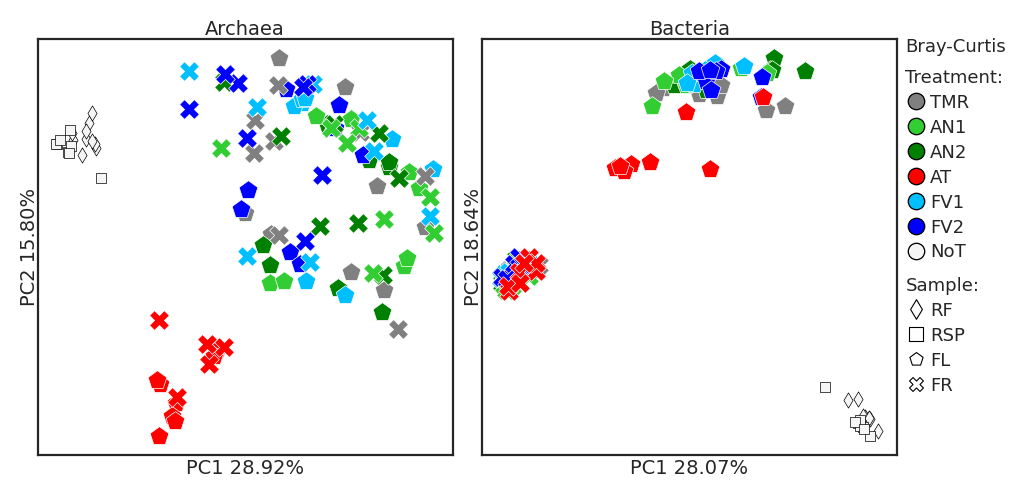

In [10]:
# Plot everything together
x, y = 1, 2 # axes to plot

for beta in BETAS:
    fig, axes = plt.subplots(1, 3, figsize=(6, 2.7), 
                             gridspec_kw={'hspace': .1, 'wspace': .1, 'width_ratios': [1,1, .1]})
    #axs, i = [[row, col] for row in range(2) for col in range(2)], 0
    for i, dom in enumerate(DOMS):
        COREM = f'Results/{dom}-Core-metrics'
        ordin, Prop = parse_pcoa(f'{COREM}/{beta}_pcoa_results.qza')
        pca_meta = META.loc[META.index.isin(ordin.index)].copy()
        ax = axes[i]
        sub() #plot scatterplot by function
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'PC{y:d} {Prop[y-1]*100:.2f}%', fontsize=7, labelpad=-4)
        ax.set_xlabel(f'PC{x:d} {Prop[x-1]*100:.2f}%', fontsize=7, labelpad=-2)
        ax.text(.5, 1.01, dom, ha='center', fontsize=7, transform=ax.transAxes)
        
    # legend
    ax = axes[-1]
    ax.axis('off')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    yax, xax = .97, -.25
    ystep, xstep = .06, 0.35
    fsize = 6.5
    ax.text(xax -.25, yax, BETAS[beta], fontdict={'size': fsize})
    
    yax -= ystep 
    ax.text(xax -.25, yax -.015, 'Treatment:', fontdict={'size': fsize})
    for c in CDICT: #colors
        yax -= ystep
        sns.scatterplot(x=[xax], y=[yax], marker='o', color=CDICT[c], ax=ax, s=35, clip_on=False, ec='black')
        ax.text(xax + xstep, yax -.015, c, fontdict={'size': fsize})

    yax -= ystep + .02
    ax.text(xax -.25, yax -.015, 'Sample:', fontdict={'size': fsize})
    for m in MDICT: #markers
        yax -= ystep
        sns.scatterplot(x=[xax], y=[yax], marker=MDICT[m], color='white', ax=ax, 
                        s=25, clip_on=False, ec='black')
        ax.text(xax + xstep, yax -.015, m, fontdict={'size': fsize})

    plt.savefig(f'Figures/Beta/PCOA_Amplicons_{beta}.png', bbox_inches='tight', facecolor='w')

In [11]:
# Melt matrix to long dataframe and add metadata
for beta in BETAS:
    for dom in DOMS:
        COREM = f'Results/{dom}-Core-metrics'
        qza = f'{COREM}/{beta}_distance_matrix.qza'
        matrix = get_matrix(qza)
        longdf = matrix.melt(ignore_index=False).reset_index()
        longdf.columns = ['ID1', 'ID2', 'Distance']
        for ind in META.index:
            longdf.loc[longdf['ID1']==ind, 'ID1_Trt'] = META.loc[ind, 'Trt']
            longdf.loc[longdf['ID2']==ind, 'ID2_Trt'] = META.loc[ind, 'Trt']
            longdf.loc[longdf['ID1']==ind, 'ID1_sType'] = META.loc[ind, 'sType']
            longdf.loc[longdf['ID2']==ind, 'ID2_sType'] = META.loc[ind, 'sType']
        longdf.to_csv(f'{COREM}/{beta}_distances_melted.tsv', sep='\t', index=False)

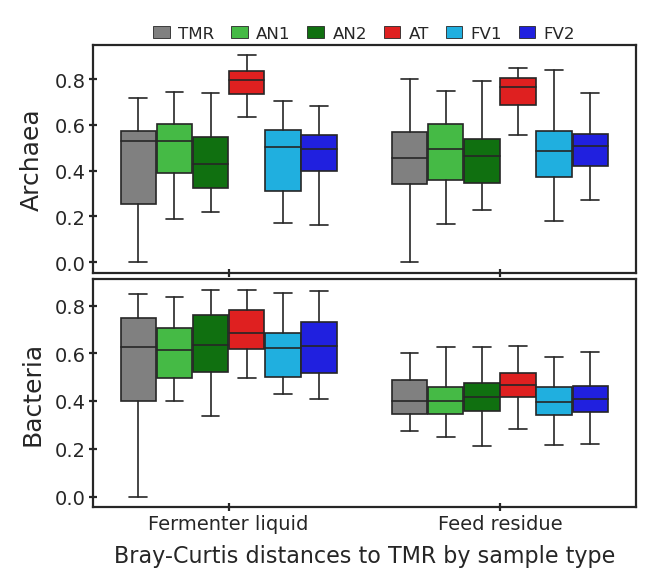

In [12]:
# Plot distances to TMR by sample type
order = ['Fermenter liquid', 'Feed residue']
horder = [k for k in CDICT.keys() if k != 'NoT']
for beta in BETAS:
    fig, axes = plt.subplots(2, 1, figsize=(3.5, 3), gridspec_kw={'hspace': .03})
    for i, dom in enumerate(DOMS):
        COREM = f'Results/{dom}-Core-metrics'
        longdf = pd.read_csv(f'{COREM}/{beta}_distances_melted.tsv', sep='\t')
        df = longdf.loc[(longdf.ID2_Trt=='TMR') & (longdf.ID1_sType==longdf.ID2_sType)].copy()
        ax = axes[i]
        df['ID1_sType'] = df['ID1_sType'].map(STYPES)
        sns.boxplot(x='ID1_sType', y='Distance', hue='ID1_Trt', data=df, ax=ax, showfliers=False,
                    palette=CDICT, fliersize=1, linewidth=.6, hue_order=horder, order=order)

        #aesthetics
        ax.tick_params(axis='both', labelsize=7, length=3, pad=1, direction='inout')
        ax.set_ylabel(dom, fontsize=9)
        ax.set_xlabel(f'{BETAS[beta]} distances to TMR by sample type', fontsize=8)
        if ax != axes[-1]:
            ax.set_xlabel('')
        
        #legend
        ax.legend(loc=9, fontsize=6, frameon=False, bbox_to_anchor=(.5, 1.15), bbox_transform=ax.transAxes, 
                  ncol=len(CDICT), handlelength=1, handletextpad=.5, columnspacing=1)        
        if ax != axes[0]:
            ax.legend().remove()
        plt.savefig(f'Figures/Beta/Boxplot_Amplicons_Trts_{beta}_.png', bbox_inches='tight', facecolor='w')

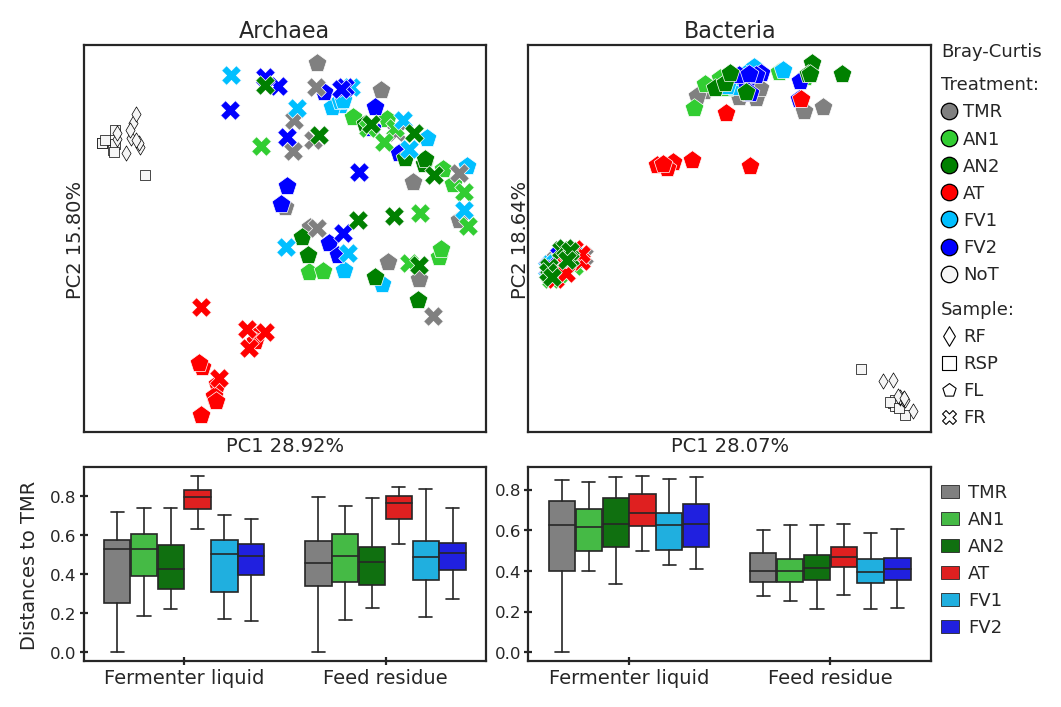

In [4]:
# Plot everything together, PCoA + distances to TMR

x, y = 1, 2 # axes to plot

for beta in BETAS:
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), gridspec_kw={'hspace': .12, 'wspace': .15, 
                             'width_ratios': [1, 1, .1], 'height_ratios': [2, 1]})
    axs, i = [[r, c] for r in range(2) for c in range(3)], 0
    
    #PCoA plot
    for dom in DOMS:
        COREM = f'Results/{dom}-Core-metrics'
        ordin, Prop = parse_pcoa(f'{COREM}/{beta}_pcoa_results.qza')
        pca_meta = META.loc[META.index.isin(ordin.index)].copy()
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
        sub() #plot scatterplot by function
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'PC{y:d} {Prop[y-1]*100:.2f}%', fontsize=7, labelpad=-4)
        ax.set_xlabel(f'PC{x:d} {Prop[x-1]*100:.2f}%', fontsize=7, labelpad=-2)
        ax.text(.5, 1.02, dom, ha='center', fontsize=8, transform=ax.transAxes)
        
        #PCoA legend
        if dom == DOMS[-1]:
            ax, i = axes[axs[i][0]][axs[i][1]], i+1
            ax.axis('off')
            ax.set_ylim(0, 1)
            ax.set_xlim(0, 1)
            yax, xax = .97, -.6
            ystep, xstep = .07, 0.35
            fsize = 6.5
            ax.text(xax -.2, yax, BETAS[beta], fontdict={'size': fsize})

            yax -= ystep 
            ax.text(xax -.2, yax -.015, 'Treatment:', fontdict={'size': fsize})
            for c in CDICT: #colors
                yax -= ystep
                sns.scatterplot(x=[xax], y=[yax], marker='o', color=CDICT[c], 
                                ax=ax, s=35, clip_on=False, ec='black')
                ax.text(xax + xstep, yax -.015, c, fontdict={'size': fsize})

            yax -= ystep + .02
            ax.text(xax -.2, yax -.015, 'Sample:', fontdict={'size': fsize})
            for m in MDICT: #markers
                yax -= ystep
                sns.scatterplot(x=[xax], y=[yax], marker=MDICT[m], color='white', ax=ax, 
                                s=25, clip_on=False, ec='black')
                ax.text(xax + xstep, yax -.015, m, fontdict={'size': fsize})
                
    # Distances to TMR            
    for dom in DOMS:
        order = ['Fermenter liquid', 'Feed residue']
        horder = [k for k in CDICT.keys() if k != 'NoT']
        COREM = f'Results/{dom}-Core-metrics'
        longdf = pd.read_csv(f'{COREM}/{beta}_distances_melted.tsv', sep='\t')
        df = longdf.loc[(longdf.ID2_Trt=='TMR') & (longdf.ID1_sType==longdf.ID2_sType)].copy()
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
        df['ID1_sType'] = df['ID1_sType'].map(STYPES)
        sns.boxplot(x='ID1_sType', y='Distance', hue='ID1_Trt', data=df, ax=ax, showfliers=False,
                    palette=CDICT, fliersize=1, linewidth=.6, hue_order=horder, order=order)

        #aesthetics
        ax.tick_params(axis='both', labelsize=6, length=3, pad=1, direction='inout')
        ax.tick_params(axis='x', labelsize=7)
        ax.set_ylabel('Distances to TMR', fontsize=7)
        ax.set_xlabel(f'', fontsize=7)
        #if ax != axes[-1]:
        #    ax.set_xlabel('')
        
        #Distances to TMR legend
        if dom == DOMS[-1]:
            ax.set_ylabel('', fontsize=7)
            handles, labels = ax.get_legend_handles_labels()
            ax.legend().remove()
            ax, i = axes[axs[i][0]][axs[i][1]], i+1
            ax.axis('off')
            
            ax.legend(handles, labels, loc=2, fontsize=fsize, frameon=False, bbox_to_anchor=(-1.2, 1), 
                      bbox_transform=ax.transAxes, handlelength=1, handletextpad=.5)        
        else:
            ax.legend().remove()

    plt.savefig(f'Figures/Beta/PCOA_Distances_Amplicons_{beta}.png', bbox_inches='tight', facecolor='w')

## Alpha diversity

### Import libraries, declare common variables

In [14]:
# Kruskal-Wallis general test + Kruskal-Wallis pairwise test for independent samples
def kw_test(df, col, metric, pairs=None, pairwise=True):
    phoc = pd.DataFrame(columns=['Group1', 'Group2', 'Mean1', 'Mean2', 'Stats', 'p'])
    kw = stats.kruskal(*[g[metric].values for n, g in df.groupby(col)])
    if kw[1] <= 0.05 and pairwise==True:
        if pairs == None: 
            pairs = combinations(df[col].unique(), 2)
        for pair in pairs:
            one, two = df.loc[df[col]==pair[0], metric].tolist(), df.loc[df[col]==pair[1], metric].tolist()
            r, p = stats.kruskal(one, two)
            phoc.loc[len(phoc)]=[pair[0], pair[1], np.average(one), np.average(two), r, p]
        phoc['q'] = multipletests(phoc.p, method='fdr_bh')[1]
    return kw, phoc

out = 'Results/Alpha_test'

!mkdir -p $out Figures/Alpha_diversity

### Add alpha metrics to metadata file

In [15]:
def add_alpha(qza):  
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    inf = f'{out}/data/alpha-diversity.tsv'
    df = pd.read_csv(inf, sep='\t', index_col=0)
    !rm -rf $out
    return df 

for dom in DOMS:
    COREM = f'Results/{dom}-Core-metrics'
    for alpha in ALPHAS:
        data = add_alpha(f'{COREM}/{alpha}_vector.qza')
        META[f'{alpha}_{dom}'] = data.iloc[:, 0]

META.to_csv('metadata.tsv',sep='\t')

### Check normality of alpha metrics

In [16]:
norm = pd.DataFrame(columns=['Metric', 'Stats', 'p'])

for dom in DOMS:
    for alpha in ALPHAS:
        metric = f'{alpha}_{dom}'
        data = META[META[metric].notna()].copy()
        i = len(norm)
        norm.loc[i, 'Domain'] = dom
        norm.loc[i, 'Metric'] = alpha
        norm.loc[i, ['Stats', 'p']] = [stats.shapiro(data[metric])[0], stats.shapiro(data[metric])[1]]

norm.to_csv(f'{out}/alpha_normality.tsv', sep='\t', index=False)    
norm

,Metric,Stats,p,Domain
0,shannon,0.982777,0.163431,Archaea
1,faith_pd,0.870823,0.0,Archaea
2,shannon,0.862763,0.0,Bacteria
3,faith_pd,0.88399,0.0,Bacteria


### Test differences between sType by KW

In [17]:
col = 'sType'

for dom in DOMS:
    summary = pd.DataFrame() 
    for alpha in ALPHAS:
        metric = f'{alpha}_{dom}'
        data = META[META[metric].notna()].copy()
        kw, phoc = kw_test(data, col, metric, pairwise=True)
        i = len(summary)
        summary.loc[i,'Metric'] = alpha
        summary.loc[i,'Factor'] = col
        summary.loc[i,'Mode'] = 'Omnibus'
        summary.loc[i,'p_gen'] = kw[1]
        summary.loc[i,'Group1'] = '-'
        summary.loc[i,'Group2'] = '-'
        summary.loc[i,'p'] = '-'
        summary.loc[i,'q'] = '-'
        if kw[1] <= 0.05:
            for ind in phoc.index:
                i = len(summary)
                summary.loc[i,'Metric'] = alpha
                summary.loc[i,'Factor'] = col
                summary.loc[i,'Mode'] = 'Post-hoc'
                summary.loc[i,'p_gen'] = kw[1]
                summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
                summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
                summary.loc[i,'p'] = phoc.loc[ind,'p']
                summary.loc[i,'q'] = phoc.loc[ind,'q']
    display(summary)
    summary.to_csv(f'{out}/{dom}_KW_sType.tsv', sep='\t')

,Metric,Factor,Mode,p_gen,Group1,Group2,p,q
0,shannon,sType,Omnibus,1.682701e-03,-,-,-,-
1,shannon,sType,Post-hoc,1.682701e-03,RSP,RF,0.075561,0.090673
2,shannon,sType,Post-hoc,1.682701e-03,RSP,FR,0.901136,0.901136
3,shannon,sType,Post-hoc,1.682701e-03,RSP,FL,0.033111,0.049667
4,shannon,sType,Post-hoc,1.682701e-03,RF,FR,0.032473,0.049667
5,shannon,sType,Post-hoc,1.682701e-03,RF,FL,0.000544,0.003262
6,shannon,sType,Post-hoc,1.682701e-03,FR,FL,0.028451,0.049667
7,faith_pd,sType,Omnibus,3.789738e-09,-,-,-,-
8,faith_pd,sType,Post-hoc,3.789738e-09,RSP,RF,0.286321,0.286321
9,faith_pd,sType,Post-hoc,3.789738e-09,RSP,FR,0.001603,0.003206


,Metric,Factor,Mode,p_gen,Group1,Group2,p,q
0,shannon,sType,Omnibus,1.450606e-18,-,-,-,-
1,shannon,sType,Post-hoc,1.450606e-18,RSP,RF,0.248213,0.248213
2,shannon,sType,Post-hoc,1.450606e-18,RSP,FR,0.000007,0.000009
3,shannon,sType,Post-hoc,1.450606e-18,RSP,FL,0.000007,0.000009
4,shannon,sType,Post-hoc,1.450606e-18,RF,FR,0.000002,0.000005
5,shannon,sType,Post-hoc,1.450606e-18,RF,FL,0.000002,0.000005
6,shannon,sType,Post-hoc,1.450606e-18,FR,FL,0.0,0.0
7,faith_pd,sType,Omnibus,1.137716e-19,-,-,-,-
8,faith_pd,sType,Post-hoc,1.137716e-19,RSP,RF,0.923342,0.923342
9,faith_pd,sType,Post-hoc,1.137716e-19,RSP,FR,0.000007,0.000011


### Test differences between Trt by KW

In [18]:
col = 'Trt'

for dom in DOMS:
    summary = pd.DataFrame() 
    for alpha in ALPHAS:
        metric = f'{alpha}_{dom}'
        for st in STYPES:
            if st in ['RSP', 'RF']:
                continue
            data = META[(META[metric].notna()) & (META['sType'] == st)].copy()
            kw, phoc = kw_test(data, col, metric, pairwise=True)
            i = len(summary)
            summary.loc[i,'Metric'] = alpha
            summary.loc[i,'Factor'] = col
            summary.loc[i,'sType'] = st
            summary.loc[i,'Mode'] = 'Omnibus'
            summary.loc[i,'p_gen'] = kw[1]
            summary.loc[i,'Group1'] = '-'
            summary.loc[i,'Group2'] = '-'
            summary.loc[i,'p'] = '-'
            summary.loc[i,'q'] = '-'
            if kw[1] <= 0.05:
                for ind in phoc.index:
                    i = len(summary)
                    summary.loc[i,'Metric'] = alpha
                    summary.loc[i,'Factor'] = col
                    summary.loc[i,'sType'] = st
                    summary.loc[i,'Mode'] = 'Post-hoc'
                    summary.loc[i,'p_gen'] = kw[1]
                    summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
                    summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
                    summary.loc[i,'p'] = phoc.loc[ind,'p']
                    summary.loc[i,'q'] = phoc.loc[ind,'q']
    display(summary)
    summary.to_csv(f'{out}/{dom}_KW_Trt.tsv', sep='\t')

,Metric,Factor,sType,Mode,p_gen,Group1,Group2,p,q
0,shannon,Trt,FL,Omnibus,0.000149,-,-,-,-
1,shannon,Trt,FL,Post-hoc,0.000149,TMR,AN1,0.293622,0.367027
2,shannon,Trt,FL,Post-hoc,0.000149,TMR,AN2,0.752714,0.752714
3,shannon,Trt,FL,Post-hoc,0.000149,TMR,AT,0.002322,0.008708
4,shannon,Trt,FL,Post-hoc,0.000149,TMR,FV1,0.59951,0.642332
5,shannon,Trt,FL,Post-hoc,0.000149,TMR,FV2,0.115184,0.191973
6,shannon,Trt,FL,Post-hoc,0.000149,AN1,AN2,0.045999,0.086249
7,shannon,Trt,FL,Post-hoc,0.000149,AN1,AT,0.004574,0.013723
8,shannon,Trt,FL,Post-hoc,0.000149,AN1,FV1,0.400814,0.462478
9,shannon,Trt,FL,Post-hoc,0.000149,AN1,FV2,0.008652,0.021629


,Metric,Factor,sType,Mode,p_gen,Group1,Group2,p,q
0,shannon,Trt,FL,Omnibus,0.123102,-,-,-,-
1,shannon,Trt,FR,Omnibus,0.167839,-,-,-,-
2,faith_pd,Trt,FL,Omnibus,0.006643,-,-,-,-
3,faith_pd,Trt,FL,Post-hoc,0.006643,TMR,AN1,0.045999,0.114998
4,faith_pd,Trt,FL,Post-hoc,0.006643,TMR,AN2,0.674424,0.722597
5,faith_pd,Trt,FL,Post-hoc,0.006643,TMR,AT,0.207578,0.311368
6,faith_pd,Trt,FL,Post-hoc,0.006643,TMR,FV1,0.011719,0.058593
7,faith_pd,Trt,FL,Post-hoc,0.006643,TMR,FV2,0.020863,0.062588
8,faith_pd,Trt,FL,Post-hoc,0.006643,AN1,AN2,0.400814,0.501018
9,faith_pd,Trt,FL,Post-hoc,0.006643,AN1,AT,0.015714,0.058929


### Test differences between sType by ANOVA

In [19]:
for dom in DOMS:
    anova, pairwise, residuals = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for alpha in ALPHAS:
        metric = f'{alpha}_{dom}'
        data = META[META[metric].notna()].copy()
        formula= f'{metric} ~ sType + Trt + rstc_run'
        results, pairwise_tests, data = run_anova(formula, data)
        results['Metric'] = pairwise_tests['Metric'] = data['Metric'] = metric
        anova = pd.concat([anova, results])
        pairwise = pd.concat([pairwise, pairwise_tests])
        residuals = pd.concat([residuals, data])
    anova.to_csv(f'{out}/{dom}_anova_sType.tsv', sep='\t')
    pairwise.to_csv(f'{out}/{dom}_anova_sType_pairs.tsv', sep='\t')
    residuals.to_csv(f'{out}/{dom}_anova_sType_residuals.tsv', sep='\t')

### Test differences between Trt by ANOVA

In [50]:
for dom in DOMS:
    anova, pairwise, residuals = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for alpha in ALPHAS:
        metric = f'{alpha}_{dom}'
        for st in STYPES:
            if st in ['RSP', 'RF']:
                continue
            data = META[(META[metric].notna()) & (META['sType'] == st)].copy()
            formula= f'{metric} ~ Trt + rstc_run'
            results, pairwise_tests, data = run_anova(formula, data)
            results['Metric'] = pairwise_tests['Metric'] = data['Metric'] = metric
            results['sType'] = pairwise_tests['sType'] = data['sType'] = st
            anova = pd.concat([anova, results])
            pairwise = pd.concat([pairwise, pairwise_tests])
            residuals = pd.concat([residuals, data])
    anova.to_csv(f'{out}/{dom}_anova_Trt.tsv', sep='\t')
    pairwise.to_csv(f'{out}/{dom}_anova_Trt_pairs.tsv', sep='\t')
    residuals.to_csv(f'{out}/{dom}_anova_Trt_residuals.tsv', sep='\t')

### Alpha stats and figures

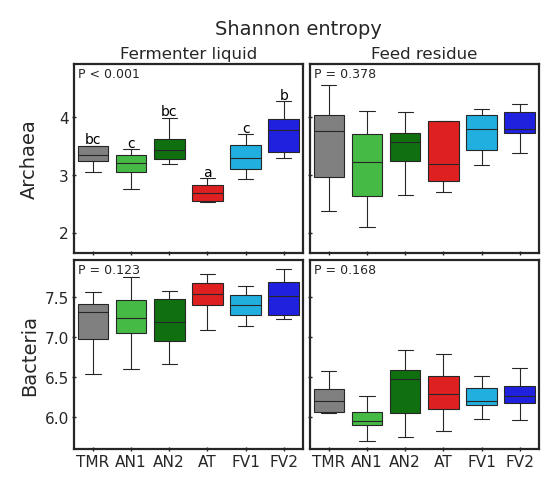

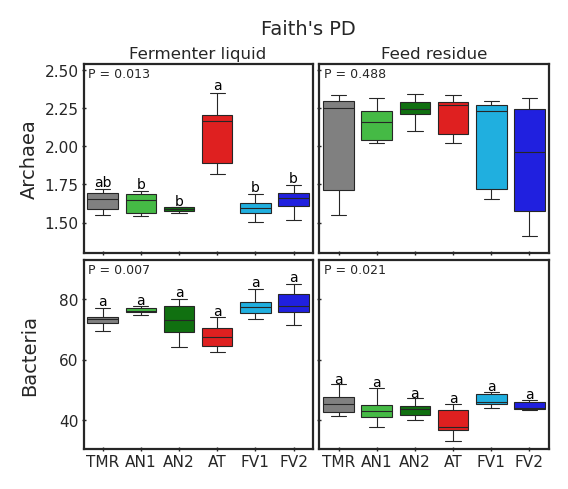

In [46]:
# by metric KW

for alpha in ALPHAS:
    if alpha not in ['shannon', 'faith_pd']: 
        continue
    metric = f'{alpha}_{dom}'
    fig, axes = plt.subplots(2, 2, figsize=(3, 2.5), sharey='row', sharex='col',
                             gridspec_kw={'hspace': .04, 'wspace': .03,}) #'width_ratios':ratios
    axs, i = [[r, c] for r in range(2) for c in range(2)], 0
    for dom in DOMS:
        summary = pd.read_csv(f'{out}/{dom}_KW_Trt.tsv', sep='\t', index_col=0)
        metric = f'{alpha}_{dom}'
        df = META[(META[metric].notna()) & (~META['sType'].isin(['RSP', 'RF']))].copy()
        ymin, ymax = df[metric].min(), df[metric].max()
        for st in STYPES:
            if st in ['RSP', 'RF']:
                continue
            data = df[(df['sType'] == st)].copy()
            order = [c for c in CDICT.keys() if c in data.Trt.tolist()]
            ax, i = axes[axs[i][0]][axs[i][1]], i+1
            sns.boxplot(x='Trt', y=metric, data=data, ax=ax, linewidth=0.4, fliersize=0.3, 
                        palette=CDICT, order=order, showfliers=False)
            ax.tick_params(axis='both', labelsize=5.5, length=1.5, pad=1, width=0.5, direction='inout')
            #ax.tick_params(axis='x', labelsize=6, labelrotation=90)
            ax.set_ylabel('')
            ax.set_xlabel('')
            if st == list(STYPES.keys())[2:][0]: 
                ax.set_ylabel(dom, fontsize=7, labelpad=2)
            if dom == DOMS[0]: 
                ax.text(.5, 1.03, STYPES[st], ha='center', fontsize=6, transform=ax.transAxes)
            
            # Statistics
            summ = summary.loc[(summary.Metric == alpha) & (summary.sType == st)]
            p_gen = round(summ["p_gen"].min(), 3)
            p = f'P = {p_gen}'
            if p_gen == 0.0:
                p = f'P < 0.001'
            ax.text(.02, .93, p, size=4.5, transform=ax.transAxes, ha='left') 
            summ = summ.loc[(summ['q'] != '-')]
            if p_gen <= .05:
                ax.set_ylim(ymin*.92, ymax*1.08)
                cld = ABCstat(summ, 'Group1', 'Group2', 'q')
                for ix, x in enumerate(order):
                    y = mpl.cbook.boxplot_stats(data.loc[data.Trt == x][metric])[0]['whishi']
                    let = cld.loc[x, 'letters']
                    ax.text(ix, y * 1.01, let, size=5, ha='center', color='black')
            
    fig.align_labels()
    fig.suptitle(ALPHAS[alpha], fontsize=7, y=.97)
    plt.savefig(f'Figures/Alpha_diversity/{alpha}-Trt.png', bbox_inches='tight', facecolor='w')

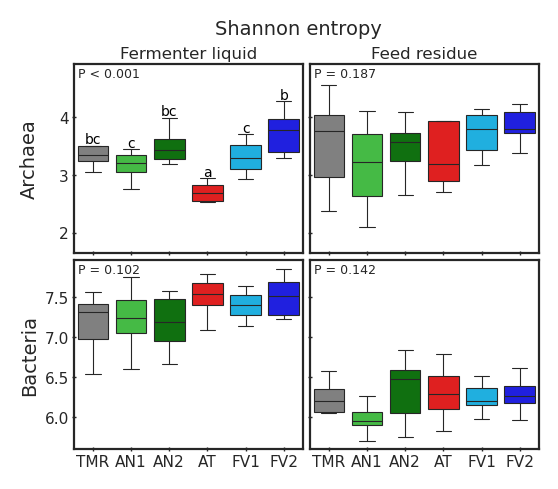

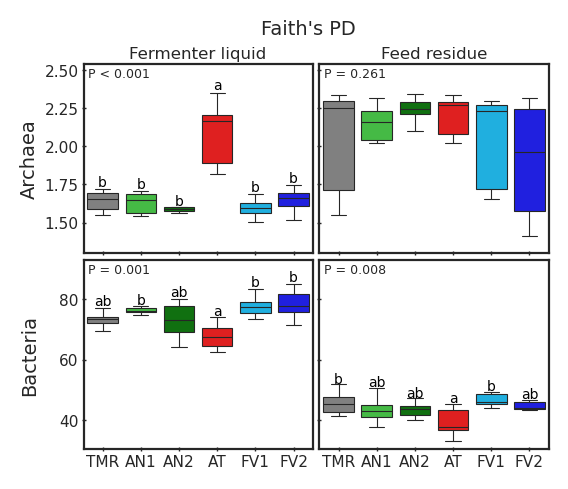

In [53]:
# by metric Anova
           
for alpha in ALPHAS:
    if alpha not in ['shannon', 'faith_pd']: 
        continue

    #set figure
    fig, axes = plt.subplots(2, 2, figsize=(3, 2.5), sharey='row', sharex='col',
                             gridspec_kw={'hspace': .04, 'wspace': .03,}) #'width_ratios':ratios
    axs, i = [[r, c] for r in range(2) for c in range(2)], 0
    
    for dom in DOMS:
        metric = f'{alpha}_{dom}'
        anova = pd.read_csv(f'{out}/{dom}_anova_Trt.tsv', sep='\t', index_col=0)
        pairs = pd.read_csv(f'{out}/{dom}_anova_Trt_pairs.tsv', sep='\t', index_col=0)
        df = META[(META[metric].notna()) & (~META['sType'].isin(['RSP', 'RF']))].copy()
        ymin, ymax = df[metric].min(), df[metric].max()

        for st in STYPES:
            if st in ['RSP', 'RF']:
                continue
            data = df[(df['sType'] == st)].copy()
            order = [c for c in CDICT.keys() if c in data.Trt.tolist()]
            ax, i = axes[axs[i][0]][axs[i][1]], i+1
            sns.boxplot(x='Trt', y=metric, data=data, ax=ax, linewidth=0.4, fliersize=0.3, 
                        palette=CDICT, order=order, showfliers=False)
            ax.tick_params(axis='both', labelsize=5.5, length=1.5, pad=1, width=0.5, direction='inout')
            #ax.tick_params(axis='x', labelsize=6, labelrotation=90)
            ax.set_ylabel('')
            ax.set_xlabel('')
            if st == list(STYPES.keys())[2:][0]: 
                ax.set_ylabel(dom, fontsize=7, labelpad=2)
            if dom == DOMS[0]: 
                ax.text(.5, 1.03, STYPES[st], ha='center', fontsize=6, transform=ax.transAxes)
                
            #Statistics
            
            #p-general
            an_sub = anova.loc[(anova.Metric == metric) & (anova.sType == st)]
            p_gen = round(an_sub.loc['Trt', 'PR(>F)'], 3)
            p = f'P = {p_gen}'
            if p_gen == 0.0:
                p = f'P < 0.001'
            ax.text(.02, .93, p, size=4.5, transform=ax.transAxes, ha='left')
            
            #p-adjusted pairwise
            if p_gen <= .05:
                ax.set_ylim(ymin*.92, ymax*1.08)
                pw_sub = pairs.loc[(pairs.Metric == metric) & (pairs.sType == st) &\
                                   (~pairs.index.str.contains('rstc'))].copy()
                pw_sub['Pair'] = pw_sub.index
                pw_sub[['Group1', 'Group2']] = pw_sub.Pair.str.split('-', expand=True)
                cld = ABCstat(pw_sub,'Group1', 'Group2', 'pvalue-fdr_bh')
                for ix, x in enumerate(order):
                    y = mpl.cbook.boxplot_stats(data.loc[data.Trt == x][metric])[0]['whishi']
                    let = cld.loc[x, 'letters']
                    ax.text(ix, y * 1.01, let, size=5, ha='center', color='black')
            
    fig.align_labels()
    fig.suptitle(ALPHAS[alpha], fontsize=7, y=.97)
    plt.savefig(f'Figures/Alpha_diversity/{alpha}-ANOVA-Trt.png', bbox_inches='tight', facecolor='w')

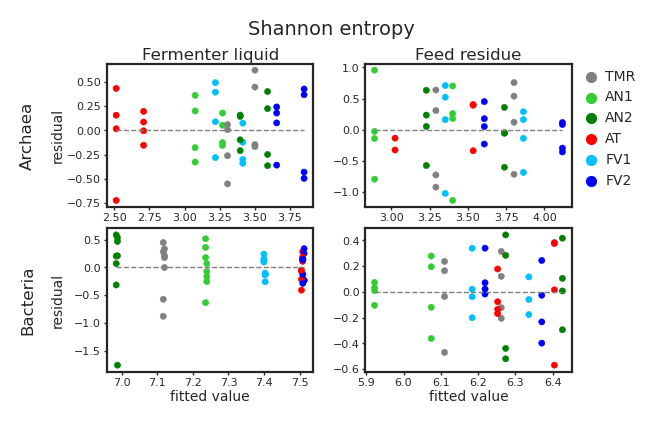

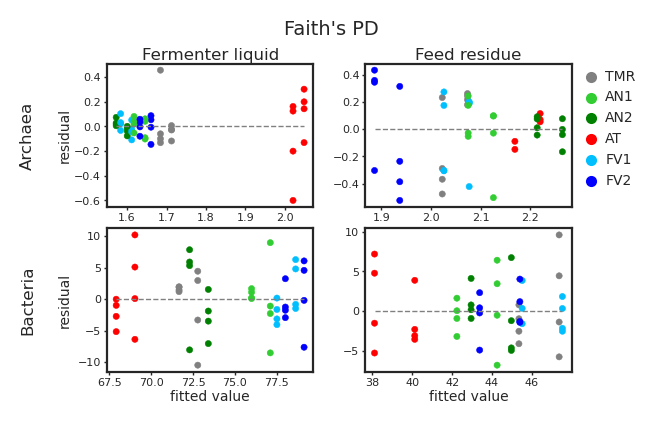

In [55]:
# Anova residuals by metric
for alpha in ALPHAS:
    if alpha not in ['shannon', 'faith_pd']: 
        continue
    
    #set figure
    fig, axes = plt.subplots(2, 2, figsize=(3, 2), 
                             gridspec_kw={'hspace': .15, 'wspace': .25}) #'width_ratios':ratios
    axs, i = [[r, c] for r in range(2) for c in range(2)], 0

    for dom in DOMS:
        rsd = pd.read_csv(f'{out}/{dom}_anova_Trt_residuals.tsv', sep='\t', index_col=0)
        metric = f'{alpha}_{dom}'

        for st in STYPES:
            if st in ['RSP', 'RF']:
                continue
            data = rsd.loc[(rsd.Metric == metric) & (rsd.sType == st)].copy()
            
            #plot
            ax, i = axes[axs[i][0]][axs[i][1]], i+1
            sns.scatterplot(x='fitted_values' ,y='residual', data=data, ax=ax, hue='Trt',\
                            palette=CDICT, s=5, edgecolor=None)
            
            #aesthetics
            xmin, xmax = data.fitted_values.min(), data.fitted_values.max()
            ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=.5, color='grey', ls='--')
            ax.tick_params(axis='both', which='major', labelsize=4, length=1, width=0.5, pad=1)
            ax.set_xlabel('fitted value', fontsize=5, labelpad=1)
            ax.set_ylabel('')
            if dom == 'Archaea': 
                ax.text(.5, 1.03, STYPES[st], ha='center', fontsize=6, transform=ax.transAxes)
                ax.set_xlabel('')
            if st == 'FL':
                ax.set_ylabel('residual', fontsize=5, labelpad=1)
                ax.text(-.42, .5, dom, va='center', fontsize=6, 
                        rotation='vertical', transform=ax.transAxes)
                
            #legend
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(labels=labels, handles=handles, borderaxespad=0, handletextpad=0,
                      fontsize=5, frameon=False, markerscale=0.5, bbox_to_anchor=(1, 1))
            if st != 'FR' or dom != 'Archaea': 
                ax.legend().remove()
                
    fig.align_labels()
    fig.suptitle(ALPHAS[alpha], fontsize=7, y=.99)
    plt.savefig(f'Figures/Alpha_diversity/{alpha}-ANOVA_residulas-Trt.png', bbox_inches='tight', facecolor='w')

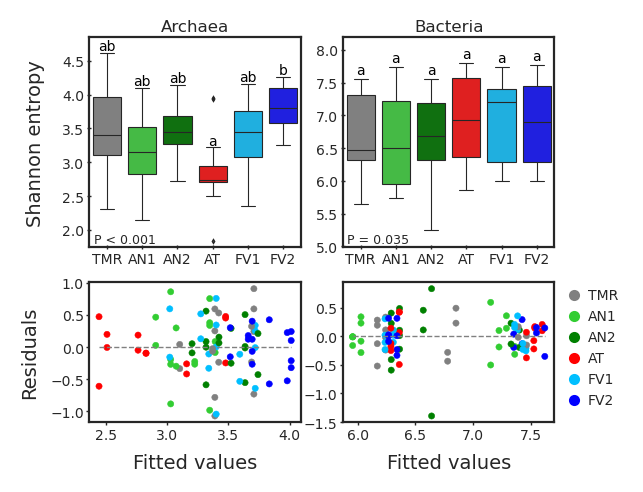

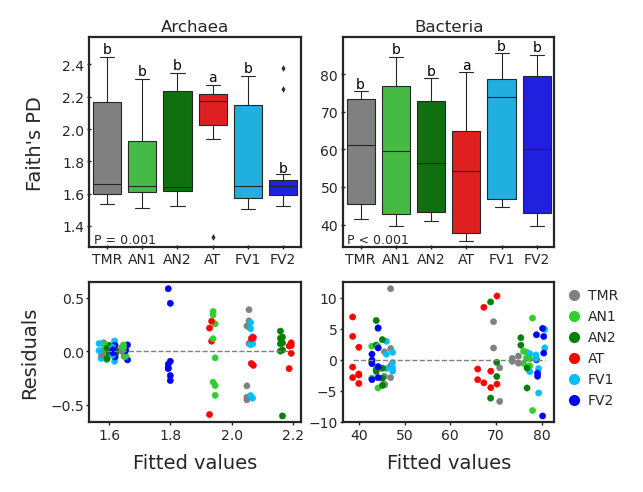

In [3]:
# by metric Anova pooled
           
for alpha in ALPHAS:
    if alpha not in ['shannon', 'faith_pd']: 
        continue

    #set figure
    fig, axes = plt.subplots(2, 2, figsize=(3, 2.5),
                gridspec_kw={'hspace': .2, 'wspace': .2, 'height_ratios': [1.5, 1]})
    axs, i = [[c, r] for r in range(2) for c in range(2)], 0
    
    for dom in DOMS:
        
        ### Boxplots ###
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
        metric = f'{alpha}_{dom}'
        anova = pd.read_csv(f'{out}/{dom}_anova_sType*Trt+rstc_run.tsv', sep='\t', index_col=0)
        pairs = pd.read_csv(f'{out}/{dom}_anova_sType*Trt+rstc_run_pairs.tsv', sep='\t', index_col=0)

        data = META[(META[metric].notna()) & (META.sType.isin(['FL', 'FR']))].copy()
        order = [c for c in CDICT.keys() if c in data.Trt.tolist()]

        sns.boxplot(x='Trt', y=metric, data=data, ax=ax, linewidth=0.4, fliersize=0.3, 
                    palette=CDICT, order=order)
        ax.tick_params(axis='both', labelsize=5, length=1.5, pad=1, width=0.5, direction='inout')
        #ax.tick_params(axis='x', labelsize=5.5, labelrotation=45)
        ax.set_ylabel('')
        ax.set_xlabel('')
        if dom == DOMS[0]: 
            ax.set_ylabel(ALPHAS[alpha], fontsize=7, labelpad=2)
        if i in [1, 3]: 
            ax.text(.5, 1.03, dom, ha='center', fontsize=6, transform=ax.transAxes)

        #Statistics
        #p-general
        an_sub = anova.loc[(anova.Metric == metric)]
        p_gen = round(an_sub.loc['Trt', 'PR(>F)'], 3)
        p = f'P = {p_gen}'
        if p_gen == 0.0:
            p = f'P < 0.001'
        ax.text(.02, .02, p, size=4.5, transform=ax.transAxes, ha='left')

        #p-adjusted pairwise
        if p_gen <= .05:
            ymin, ymax = data[metric].min(), data[metric].max()
            ax.set_ylim(ymin*.95, ymax*1.05)
            pw_sub = pairs.loc[(pairs.Metric == metric) &\
                               (~pairs.index.str.contains('rstc|FR|E|FL'))].copy()
            pw_sub['Pair'] = pw_sub.index
            pw_sub[['Group1', 'Group2']] = pw_sub.Pair.str.split('-', expand=True)
            cld = ABCstat(pw_sub,'Group1', 'Group2', 'pvalue-fdr_bh')
            for ix, x in enumerate(order):
                y = mpl.cbook.boxplot_stats(data.loc[data.Trt == x][metric])[0]['whishi']
                let = cld.loc[x, 'letters']
                ax.text(ix, y * 1.01, let, size=5, ha='center', color='black')
                
        ### residuals ###
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
        rsd = pd.read_csv(f'{out}/{dom}_anova_sType*Trt+rstc_run_residuals.tsv', sep='\t', index_col=0)
        metric = f'{alpha}_{dom}'
        data = rsd.loc[(rsd.Metric == metric)].copy()

        #plot
        sns.scatterplot(x='fitted_values' ,y='residual', data=data, ax=ax, hue='Trt',\
                        palette=CDICT, s=5, edgecolor=None)

        #aesthetics
        xmin, xmax = data.fitted_values.min(), data.fitted_values.max()
        ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=.5, color='grey', ls='--')
        ax.tick_params(axis='both', which='major', labelsize=5, length=1, width=0.5, pad=1)
        ax.set_xlabel('Fitted values', fontsize=7)
        ax.set_ylabel('')
        #if dom == 'Archaea': 
        #    ax.text(.5, 1.03, STYPES[st], ha='center', fontsize=6, transform=ax.transAxes)
        #    ax.set_xlabel('')
        if dom == DOMS[0]:
            ax.set_ylabel('Residuals', fontsize=7)
            #ax.text(-.42, .5, dom, va='center', fontsize=6, 
            #        rotation='vertical', transform=ax.transAxes)

        #legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(labels=labels, handles=handles, borderaxespad=0, handletextpad=0,
                  fontsize=5, frameon=False, markerscale=0.5, bbox_to_anchor=(1, 1))
        if dom != DOMS[-1]: 
            ax.legend().remove()
            
    fig.align_labels()
    #fig.suptitle(ALPHAS[alpha], fontsize=7, y=.97)
    plt.savefig(f'Figures/Alpha_diversity/{alpha}-ANOVA-Trt-pooled.png', bbox_inches='tight', facecolor='w')

# Taxabarplots

In [ ]:
!pip install colorcet

In [56]:
!mkdir -p Results/Taxabarplots

for dom in DOMS:
    TAXA = f'Data/{dom}-taxonomy.qza'
    TABLE = f'{TABS}/{dom}-table.qza'
    barplot = f'Results/Taxabarplots/{dom}-taxabarplot.qzv'

    !qiime taxa barplot \
        --i-table $TABLE \
        --i-taxonomy $TAXA \
        --m-metadata-file metadata.tsv \
        --o-visualization $barplot

Saved Visualization to: Results/Taxabarplots/Archaea-taxabarplot.qzv
Saved Visualization to: Results/Taxabarplots/Bacteria-taxabarplot.qzv


## Import libraries and declare variables

In [57]:
colours = cc.glasbey_hv
del colours[26] #remove white color


def bar_unzip(qza, lev):    
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ', '')
    inf = digest + f'/data/level-{lev}.csv'
    data = pd.read_csv(inf, sep=',', index_col=0)
    !rm -rf $digest
    return data


!mkdir -p Figures/Taxabarplots

### Taxabarplots by sType

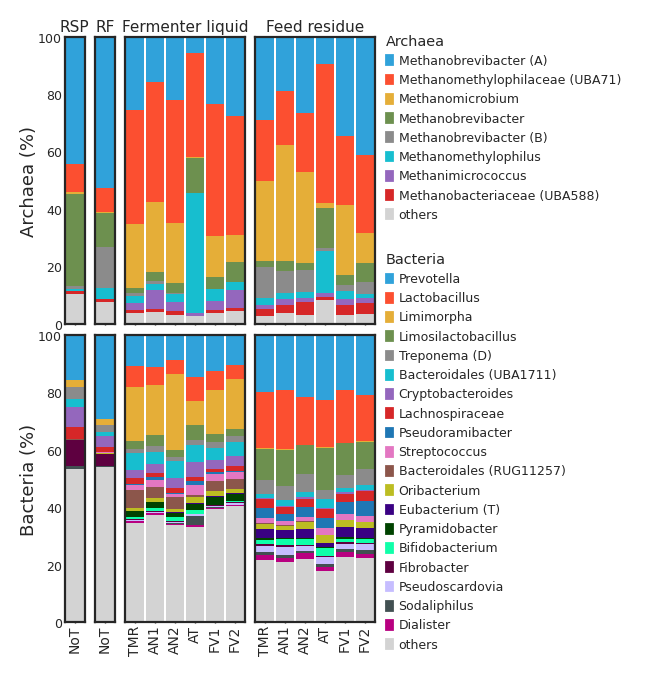

In [71]:
drep = {
    '_': ' ',
    '  ;': '',
    'UBA71': 'Methanomethylophilaceae (UBA71)',
    'UBA588': 'Methanobacteriaceae (UBA588)',
    'Methanobrevibacter A': 'Methanobrevibacter (A)',
    'Methanobrevibacter B': 'Methanobrevibacter (B)',
    'Treponema D': 'Treponema (D)',
    'UBA1711': 'Bacteroidales (UBA1711)',
    'RUG11257': 'Bacteroidales (RUG11257)',
    'Eubacterium T': 'Eubacterium (T)',}

tops = [8, 19]

#figure
ratios = [len(META.loc[META.sType==st].Trt.unique()) for st in STYPES]
fig, axes = plt.subplots(2, len(STYPES), figsize=(2, 3.8), sharey='row', sharex='col',
                         gridspec_kw={'wspace': .15, 'hspace': .04, 'width_ratios':ratios})
axs, i = [[r, c] for r in range(2) for c in range(len(STYPES))], 0
    
for j, dom in enumerate(DOMS):
    df = bar_unzip(f'Results/Taxabarplots/{dom}-taxabarplot.qzv', 6)
    df = df[[col for col in df.columns if 'p__' in col]]
    for k, v in drep.items():
        df.columns = [c.replace(k, v) for c in df.columns]
    temp = df.copy()
    df.columns = [c.strip( ).strip(';').split('  ')[-1] for c in df.columns]
    #[print(pair) for pair in zip(temp.columns, df.columns)]
    meta = META.loc[df.index].copy()
    df = df.groupby(level=0, axis=1).sum() #sum duplicates
    df.loc['mean', :] = df.mean() #add a row with mean 
    df.sort_values(inplace=True, axis=1, by='mean', ascending=True) #sort features by mean of abundances
    df.drop(inplace=True, index='mean')
    df = df.div(df.sum(axis=1), axis=0) * 100 #convert to % (rel ab)
    df = df[df.columns.tolist()[-tops[j]:]]
    df.to_csv(f'Results/Taxabarplots/relative-{dom}.tsv', sep='\t')
    
    #define colors
    cdict = dict(zip(df.columns.tolist()[::-1], colours))
                 
    #legend
    legend = []
    
    #by sType
    for st in STYPES:
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
        md = meta.loc[meta.sType == st].copy()
        data = df.loc[md.index].copy()
        data.to_csv(f'Results/Taxabarplots/relative-{dom}-{st}.tsv', sep='\t')
        
        #mean rel abund by diets
        data['Trt'] = md.Trt
        data.set_index('Trt', inplace=True)
        data = data.groupby(level='Trt').mean()
        data = data.reindex([trt for trt in CDICT if trt in data.index])
        data.to_csv(f'Results/Taxabarplots/relative-by-sType-{dom}-{st}.tsv', sep='\t')       

        bottom = [100 - data.loc[j,:].sum() for j in data.index] #starting points for stacked barplot
        ax.bar(x=data.index, height=bottom, color='lightgrey', width=.9, linewidth=0)
        for col in data.columns: #iterate through all features
            c = cdict[col] #define color
            if col not in legend: 
                legend = [col] + legend #add color to legend
            ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, label=col, width=.9, linewidth=0)
            bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom
        
        #aesthetics
        ax.tick_params(axis='both', labelsize=4.5, pad=.5, length=.5, width=0.5) #adjust ticks
        ax.tick_params(axis='x', labelsize=5, labelrotation=90) #adjust ticks
        ax.set_ylim(0, 100) #set limit for y axis
        ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
        if st == list(STYPES.keys())[0]:
            ax.set_ylabel(f'{dom} (%)', fontsize=6.5, labelpad=0)
        if dom == DOMS[0]:
            ax.text(.5, 1.02, STYPES[st], ha='center', fontsize=5.5, transform=ax.transAxes)
            
        #legend
        if st == list(STYPES.keys())[-1]:
            labels = [l for l in df.columns[::-1] if l in legend] + ['others']                     
            handles = [mpatches.Patch(color='lightgrey', label=l) if l == 'others' \
                      else mpatches.Patch(color=cdict[l], label=l) for l in labels]
            ypos = 1.05
            if dom == 'Bacteria': 
                ypos = 1.33
            leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(1, ypos), fontsize=4.5, frameon=False,
                            handletextpad=0.5, handlelength=0.5, bbox_transform=ax.transAxes, 
                            title=dom, title_fontsize=5.2)  
            leg._legend_box.align = "left"
plt.savefig(f'Figures/Taxabarplots/Taxabarplot_sType.png', bbox_inches='tight', facecolor='w')

## Statistical analysis of top features in barplots

In [61]:
# Kruskal-Wallis general test + Kruskal-Wallis pairwise test for independent samples
def kw_test(df, col, metric, pairs=False, pairwise=False):
    phoc = pd.DataFrame(columns=['Group1', 'Group2', 'Mean1', 'Mean2', 'Stats', 'p'])
    kw = stats.kruskal(*[g[metric].values for n, g in df.groupby(col)])
    if kw[1] <= 0.05 and pairwise == True:
        if pairs == False: 
            pairs = combinations(df[col].unique(), 2)
        for pair in pairs:
            one = df.loc[df[col] == pair[0], metric].tolist()
            two = df.loc[df[col] == pair[1], metric].tolist()
            if min(one) == max(one) == min(two) == max(two) == 0:
                continue
            r, p = stats.kruskal(one, two)
            phoc.loc[len(phoc)] = [pair[0], pair[1], np.average(one), np.average(two), r, p]
        phoc['q'] = multipletests(phoc.p, method='fdr_bh')[1]
    return kw, phoc


for dom in DOMS:
    df = pd.read_csv(f'Results/Taxabarplots/relative-{dom}.tsv', sep='\t', index_col=0)
    df = df[df.columns[-8:]]
    meta = META.loc[df.index.tolist(),:].copy()
    data = pd.concat([meta, df], axis=1)
    
    # Between sample-types
    summary = pd.DataFrame()
    for feat in df.columns:
        kw, phoc = kw_test(data, 'sType', feat, pairwise=True)
        if kw[1] <= 0.05:
            for ind in phoc.index:
                i = len(summary)
                summary.loc[i,'Feature'] = feat
                summary.loc[i,'KW'] = kw[1]
                summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
                summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
                summary.loc[i,'p'] = phoc.loc[ind,'p']
                summary.loc[i,'q'] = phoc.loc[ind,'q']
        else:
            i = len(summary)
            summary.loc[i,'Feature'] = feat
            summary.loc[i,'KW'] = kw[1]
            summary.loc[i,'Group1'] = '-'
            summary.loc[i,'Group2'] = '-'
            summary.loc[i,'p'] = '-'
            summary.loc[i,'q'] = '-'
            
    summary.to_csv(f'Results/Taxabarplots/KW_sType_{dom}.tsv', sep='\t')
    
    # Between treatments by sample-types
    summary = pd.DataFrame()
    for st in 'FL', 'FR':
        stdata = data.loc[data.sType == st].copy()
        for feat in df.columns:
            kw, phoc = kw_test(stdata, 'Trt', feat, pairwise=True)
            if kw[1] <= 0.05:
                for ind in phoc.index:
                    i = len(summary)
                    summary.loc[i,'sType'] = st
                    summary.loc[i,'Feature'] = feat
                    summary.loc[i,'KW'] = kw[1]
                    summary.loc[i,'Group1'] = phoc.loc[ind,'Group1']
                    summary.loc[i,'Group2'] = phoc.loc[ind,'Group2']
                    summary.loc[i,'p'] = phoc.loc[ind,'p']
                    summary.loc[i,'q'] = phoc.loc[ind,'q']
            else:
                i = len(summary)
                summary.loc[i,'sType'] = st
                summary.loc[i,'Feature'] = feat
                summary.loc[i,'KW'] = kw[1]
                summary.loc[i,'Group1'] = '-'
                summary.loc[i,'Group2'] = '-'
                summary.loc[i,'p'] = '-'
                summary.loc[i,'q'] = '-'
    summary.to_csv(f'Results/Taxabarplots/Trts_{dom}.tsv', sep='\t')

# ANCOM BC

In [62]:
#export taxa
for dom in DOMS:
    taxin = f'Data/{dom}-taxonomy.qza'
    
    !qiime tools export \
        --input-path $taxin \
        --output-path Data/$dom-taxonomy

Exported Data/Archaea-taxonomy.qza as TSVTaxonomyDirectoryFormat to directory Data/Archaea-taxonomy
Exported Data/Bacteria-taxonomy.qza as TSVTaxonomyDirectoryFormat to directory Data/Bacteria-taxonomy


In [63]:
#run AncomBC

for dom in DOMS:
    TABLE = f'{TABS}/{dom}-table.qza'
    
    #filter by sample type and RA
    for st in STYPES:
        if st in ['RSP', 'RF']:
            continue
        outdir = f'Results/AncomBC/{dom}-{st}'
        retain = f"[sType]='{st}'"
        tabex = f'{outdir}/table.qza'
        ancom = f'{outdir}/differentials.qza'
        ancov = f'{outdir}/da-barplot.qzv'

        !mkdir -p $outdir

        #filter by sample type
        !qiime feature-table filter-samples \
            --i-table $TABLE \
            --m-metadata-file metadata.tsv \
            --p-where "$retain" \
            --o-filtered-table $tabex

        #filer by relative abundances
        !qiime feature-table filter-features-conditionally \
            --i-table $tabex \
            --p-abundance .01 \
            --p-prevalence .2 \
            --o-filtered-table $tabex
        
        #run ancom-bc
        !qiime composition ancombc \
            --i-table $tabex \
            --m-metadata-file metadata.tsv \
            --p-formula 'Trt + rstc_run' \
            --p-reference-levels Trt::TMR \
            --o-differentials $ancom
        
        #da-barplot
        !qiime composition da-barplot \
            --i-data $ancom \
            --o-visualization $ancov

Saved FeatureTable[Frequency] to: Results/AncomBC/Archaea-FL/table.qza
Saved FeatureTable[Frequency] to: Results/AncomBC/Archaea-FL/table.qza
Saved FeatureData[DifferentialAbundance] to: Results/AncomBC/Archaea-FL/differentials.qza
Saved Visualization to: Results/AncomBC/Archaea-FL/da-barplot.qzv
Saved FeatureTable[Frequency] to: Results/AncomBC/Archaea-FR/table.qza
Saved FeatureTable[Frequency] to: Results/AncomBC/Archaea-FR/table.qza
Saved FeatureData[DifferentialAbundance] to: Results/AncomBC/Archaea-FR/differentials.qza
Saved Visualization to: Results/AncomBC/Archaea-FR/da-barplot.qzv
Saved FeatureTable[Frequency] to: Results/AncomBC/Bacteria-FL/table.qza
Saved FeatureTable[Frequency] to: Results/AncomBC/Bacteria-FL/table.qza
Saved FeatureData[DifferentialAbundance] to: Results/AncomBC/Bacteria-FL/differentials.qza
Saved Visualization to: Results/AncomBC/Bacteria-FL/da-barplot.qzv
Saved FeatureTable[Frequency] to: Results/AncomBC/Bacteria-FR/table.qza
Saved FeatureTable[Frequency] 

In [72]:
#merge Ancom-BC outputs

#get effect sizes and q-values
def anconbc_unzip(qza):    
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    lfc = pd.read_csv(f'{out}/data/lfc_slice.csv', sep=',')
    qval = pd.read_csv(f'{out}/data/q_val_slice.csv', sep=',')
    !rm -rf $out
    return lfc, qval


summ = pd.DataFrame()
for dom in DOMS:
    for st in STYPES:
        if st in ['RSP', 'RF']:
            continue
        outdir = f'Results/AncomBC/{dom}-{st}'
        ancom = f'{outdir}/differentials.qza'
        lfc, qval = anconbc_unzip(ancom)
        lfc = lfc.melt(id_vars='id', value_name='LFC', var_name='Trt')
        qval = qval.melt(id_vars='id', value_name='qval', var_name='Trt')
        lfc['qval'] = qval['qval']
        lfc = lfc.loc[~lfc.Trt.isin(['(Intercept)', 'rstc_runrstc_run2'])]
        lfc.Trt = lfc.Trt.str.replace('Trt', '')
        lfc[['sType', 'Domain']] = st, dom
        summ = pd.concat([summ, lfc])
summ = summ.loc[summ['qval'] <= .05]
display(summ)
summ.to_csv(f'Results/AncomBC/summ.tsv', sep='\t') 

,id,Trt,LFC,qval,sType,Domain
22,631269ab9cbf2bd5bd0495edc4d90dd5,AN1,-0.541389,0.001253,FL,Archaea
23,018d29a002e68c0e3f2a5961567395ca,AN1,0.767743,0.000962,FL,Archaea
27,9a99f8d6fc17c10857a85423778f0021,AN1,-0.703234,0.000142,FL,Archaea
35,a60168264ec100a5b565b13c6ae75315,AN1,-0.649924,0.000128,FL,Archaea
48,9a99f8d6fc17c10857a85423778f0021,AN2,-0.470959,0.034333,FL,Archaea
...,...,...,...,...,...,...
93,922217d724c8ed96a6e92be9b81cc7fb,AN2,3.660741,0.001557,FR,Bacteria
100,54dcd9eb03c245d3eb6052d2e3a4920a,AT,1.807920,0.000001,FR,Bacteria
116,92cea1a02be0d84cbcaab2f1fe1648c9,AT,0.909094,0.013265,FR,Bacteria
157,922217d724c8ed96a6e92be9b81cc7fb,FV1,3.594459,0.004057,FR,Bacteria


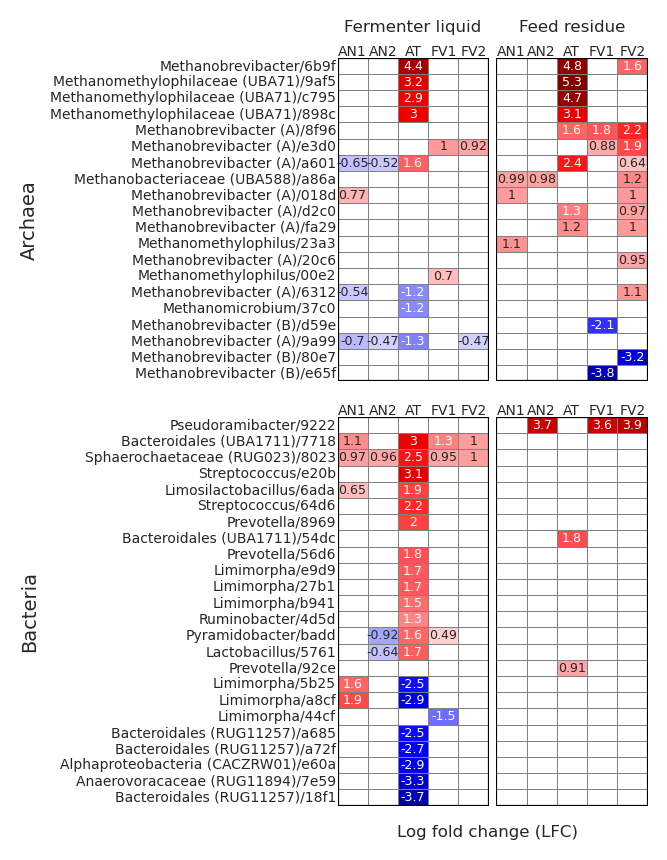

In [76]:
# plot
!mkdir -p Figures/AncomBC

#dictionary to modify taxa IDs
drep = {
    'UBA71': 'Methanomethylophilaceae (UBA71)',
    'UBA588': 'Methanobacteriaceae (UBA588)',
    'Methanobrevibacter_A': 'Methanobrevibacter (A)',
    'Methanobrevibacter_B': 'Methanobrevibacter (B)',
    'JAJGRE01': 'Lutisporaceae (JAJGRE01)',
    'UBA1711': 'Bacteroidales (UBA1711)',
    'RUG023': 'Sphaerochaetaceae (RUG023)',
    'CACZRW01': 'Alphaproteobacteria (CACZRW01)',
    'RUG11257': 'Bacteroidales (RUG11257)',
    'RUG11894': 'Anaerovoracaceae (RUG11894)',
    '_': ' ',}

#read summary
summ = pd.read_csv(f'Results/AncomBC/summ.tsv', sep='\t', index_col=0) #LEfSe summary
vmax = summ.LFC.max()
vmin = summ.LFC.min()

S = 14 #scale figure size
H = len(summ.index.unique())/S #heiht of figure
step = H/len(summ.index.unique()) #height of 1 line
sorter = list(CDICT.keys())[1:-1] #columns to plot
stypes = ['FL', 'FR']

#learn heights of subplots and order of ids
grouped = pd.DataFrame(summ.groupby('id')['LFC'].sum())
grouped.sort_values(by='LFC', ascending=False, inplace=True)
order = grouped.index.tolist()
id_order = [summ.loc[summ.Domain == dom].id.unique().tolist() for dom in DOMS]
id_order = [[i for i in order if i in l] for l in id_order]
heights = [len(l) for l in id_order]

#set figure
fig, axes = plt.subplots(len(DOMS), len(stypes), figsize=(len(stypes), H + 2*step), sharey='row',
                         gridspec_kw={'height_ratios': heights, 'wspace': .05, 'hspace': .1})
axs, i = [[r, c] for r in range(len(DOMS)) for c in range(len(stypes))], 0

for j, dom in enumerate(DOMS):
    for st in stypes:
        df = summ.loc[(summ.Domain == dom) & (summ.sType == st)].copy()
        hdf = df.pivot(index='id', columns='Trt', values='LFC')
        
        #sort columns
        for col in sorter:
            if col not in hdf.columns:
                hdf[col] = np.nan
        hdf = hdf[sorter]
    
        #sort rows
        for ind in id_order[j]:
            if ind not in hdf.index:
                hdf.loc[ind, :] = np.nan
        hdf = hdf.reindex(id_order[j])
        
        #add taxonomy to IDs
        taxa = pd.read_csv(f'Data/{dom}-taxonomy/taxonomy.tsv', sep='\t', index_col=0)
        hdf['Taxa'] = taxa.Taxon
        #hdf['id'] = hdf['Taxa'].str.rsplit('__', n=1).str[-1].str.split(' sp').str[0]\
        #            +'/'+ hdf.index.str[:4]
        hdf.loc[hdf.Taxa.str.contains(';g__'), 'id'] = hdf.loc[hdf.Taxa.str.contains(';g__')]['Taxa']\
                                    .str.rsplit('g__', n=1).str[-1].str.rsplit(';', n=1).str[0]\
                                    +'/'+ hdf.loc[hdf.Taxa.str.contains(';g__')].index.str[:4]
        hdf.loc[~hdf.Taxa.str.contains(';g__'), 'id'] = hdf.loc[~hdf.Taxa.str.contains(';g__')]['Taxa']\
                                    .str.rsplit('__', n=1).str[-1].str.split(';').str[0]\
                                    +'/'+ hdf.loc[~hdf.Taxa.str.contains(';g__')].index.str[:4]
        
        #replace some susTypetrings in IDs
        for k, v in drep.items():
            hdf.id = hdf.id.apply(lambda x: x.replace(k, v))
        hdf.set_index('id', inplace=True)
        hdf = hdf[sorter]
        
        #plot
        ax, i = axes[axs[i][0]][axs[i][1]], i+1
        sns.heatmap(data=hdf, ax=ax, annot=True, cbar=False, square=False, center=0, cmap='seismic', 
                    xticklabels=False, yticklabels=True, annot_kws={"size":4.5}, linewidths=.3, 
                    linecolor='grey', vmax=vmax, vmin=vmin)
        
        #aesthetics
        ax.set_xlabel('')
        ax.set_ylabel('')
        if st == 'FL':
            ax.set_ylabel(dom, fontsize=7)
        ax.tick_params(rotation=0, axis='both', labelsize=5, length=0, pad=.5)
        
        #subtitle
        if dom == DOMS[0]:
            ax.text(len(sorter)/2, -1.6, STYPES[st], ha='center', fontsize=6, 
                    transform=ax.transData)
        
        #annotate 
        for pos, lab in enumerate(sorter):
            ax.text(pos+.5, -.8, lab, size=5, ha='center', va='top', transform=ax.transData)
            
        #lines around axes
        ax.axhline(y=0, color='k',linewidth=.8)
        ax.axhline(y=len(hdf), color='k',linewidth=.8)
        ax.axvline(x=0, color='k',linewidth=.8)
        ax.axvline(x=len(sorter), color='k',linewidth=.8)
        
fig.align_labels()
fig.suptitle('Log fold change (LFC)', fontsize=6, y=.09, x=.5)
plt.savefig('Figures/AncomBC/AncomBC.png', bbox_inches='tight', facecolor='w')

In [8]:
#run AncomBC

for dom in DOMS:
    TABLE = f'{TABS}/{dom}-table.qza'
    outdir = f'Results/Ancom-BC/{dom}'
    retain = f"[sType] IN ('FL', 'FR')"
    tabex = f'{outdir}/table.qza'
    ancom = f'{outdir}/differentials.qza'
    ancov = f'{outdir}/da-barplot.qzv'

    !mkdir -p $outdir

    #filter by sample type
    !qiime feature-table filter-samples \
        --i-table $TABLE \
        --m-metadata-file metadata.tsv \
        --p-where "$retain" \
        --o-filtered-table $tabex
    
    #filer by relative abundances
    !qiime feature-table filter-features-conditionally \
        --i-table $tabex \
        --p-abundance .01 \
        --p-prevalence .1 \
        --o-filtered-table $tabex

    #run ancom-bc
    !qiime composition ancombc \
        --i-table $tabex \
        --m-metadata-file metadata.tsv \
        --p-formula 'Trt + sType + rstc_run' \
        --p-reference-levels Trt::TMR \
        --o-differentials $ancom

    #da-barplot
    !qiime composition da-barplot \
        --i-data $ancom \
        --o-visualization $ancov

Saved FeatureTable[Frequency] to: Results/Ancom-BC/Archaea/table.qza
Saved FeatureTable[Frequency] to: Results/Ancom-BC/Archaea/table.qza
Saved FeatureData[DifferentialAbundance] to: Results/Ancom-BC/Archaea/differentials.qza
Saved Visualization to: Results/Ancom-BC/Archaea/da-barplot.qzv
Saved FeatureTable[Frequency] to: Results/Ancom-BC/Bacteria/table.qza
Saved FeatureTable[Frequency] to: Results/Ancom-BC/Bacteria/table.qza
Saved FeatureData[DifferentialAbundance] to: Results/Ancom-BC/Bacteria/differentials.qza
Saved Visualization to: Results/Ancom-BC/Bacteria/da-barplot.qzv


In [9]:
#merge Ancom-BC outputs

#get effect sizes and q-values
def anconbc_unzip(qza):    
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    lfc = pd.read_csv(f'{out}/data/lfc_slice.csv', sep=',')
    qval = pd.read_csv(f'{out}/data/q_val_slice.csv', sep=',')
    !rm -rf $out
    return lfc, qval


summ = pd.DataFrame()
for dom in DOMS:
    outdir = f'Results/Ancom-BC/{dom}'
    ancom = f'{outdir}/differentials.qza'
    lfc, qval = anconbc_unzip(ancom)
    lfc = lfc.melt(id_vars='id', value_name='LFC', var_name='Trt')
    qval = qval.melt(id_vars='id', value_name='qval', var_name='Trt')
    lfc['qval'] = qval['qval']
    lfc = lfc.loc[lfc.Trt.str.contains('Trt')]
    lfc.Trt = lfc.Trt.str.replace('Trt', '')
    lfc['Domain'] = dom
    summ = pd.concat([summ, lfc])
summ = summ.loc[summ['qval'] <= .05]
display(summ)
summ.to_csv(f'Results/Ancom-BC/summ.tsv', sep='\t') 

,id,Trt,LFC,qval,Domain
28,631269ab9cbf2bd5bd0495edc4d90dd5,AN1,-0.599956,5.980774e-04,Archaea
29,018d29a002e68c0e3f2a5961567395ca,AN1,0.592334,8.317109e-03,Archaea
34,9a99f8d6fc17c10857a85423778f0021,AN1,-0.766223,1.118764e-04,Archaea
36,48e85a9a857b4a2519ae19161151bd77,AN1,2.897424,2.944062e-03,Archaea
37,23a3c9b6f70376eadf564b74d5bdf3c7,AN1,0.988038,4.440607e-02,Archaea
44,a60168264ec100a5b565b13c6ae75315,AN1,-0.728095,1.200290e-05,Archaea
60,6b9f5b5a093f302fa3b606bd48968cc0,AN2,0.466671,1.149639e-02,Archaea
67,e3d026061d084107a6d9c7abafa067cb,AN2,1.004382,6.160007e-04,Archaea
69,a86a104c488483155f1a146cb2454b8f,AN2,0.719407,9.620554e-04,Archaea
82,631269ab9cbf2bd5bd0495edc4d90dd5,AT,-1.871248,1.150663e-10,Archaea


Trt,AN1,AN2,AT,FV1,FV2
id,,,,,
Methanomethylophilus/23a3,0.988038,NaN,5.237487,NaN,NaN
Methanobrevibacter/6b9f,NaN,0.466671,3.554593,NaN,0.756968
Methanobrevibacter (A)/8f96,NaN,NaN,NaN,1.904857,1.578025
Methanomethylophilaceae (UBA71)/9af5,NaN,NaN,2.958542,NaN,NaN
Methanimicrococcus/48e8,2.897424,NaN,NaN,NaN,NaN
Methanomethylophilaceae (UBA71)/c795,NaN,NaN,2.556186,NaN,NaN
Methanomethylophilaceae (UBA71)/898c,NaN,NaN,1.971095,NaN,NaN
Methanobrevibacter (A)/e3d0,NaN,1.004382,-1.589855,0.892084,0.963150
Methanobacteriaceae (UBA588)/a86a,NaN,0.719407,NaN,NaN,NaN


Trt,AN1,AN2,AT,FV1,FV2
id,,,,,
Pseudoramibacter/9222,NaN,NaN,NaN,2.747828,2.421117
Limimorpha/5b25,1.578272,2.176928,-3.049201,1.760789,NaN
Bacteroidales (UBA1711)/54dc,NaN,NaN,2.176573,NaN,NaN
Limosilactobacillus/b4ec,1.921116,NaN,NaN,NaN,NaN
Limosilactobacillus/8587,1.903214,NaN,NaN,NaN,NaN
Treponema (D)/7713,NaN,1.032568,NaN,0.852278,NaN
Streptococcus/e20b,NaN,NaN,1.661142,NaN,NaN
Prevotella/92ce,NaN,NaN,1.192685,NaN,NaN
Prevotella/429f,NaN,NaN,NaN,0.797124,NaN


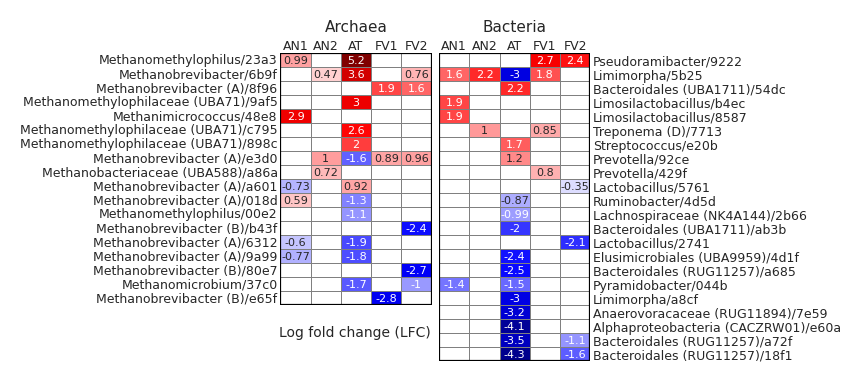

In [4]:
# plot
!mkdir -p Figures/AncomBC

#dictionary to modify taxa IDs
drep = {
    'UBA71': 'Methanomethylophilaceae (UBA71)',
    'UBA588': 'Methanobacteriaceae (UBA588)',
    'Methanobrevibacter_A': 'Methanobrevibacter (A)',
    'Methanobrevibacter_B': 'Methanobrevibacter (B)',
    'JAJGRE01': 'Lutisporaceae (JAJGRE01)',
    'UBA1711': 'Bacteroidales (UBA1711)',
    'RUG023': 'Sphaerochaetaceae (RUG023)',
    'CACZRW01': 'Alphaproteobacteria (CACZRW01)',
    'RUG11257': 'Bacteroidales (RUG11257)',
    'RUG11894': 'Anaerovoracaceae (RUG11894)',
    'Treponema_D': 'Treponema (D)',
    'UBA9959': 'Elusimicrobiales (UBA9959)',
    'NK4A144': 'Lachnospiraceae (NK4A144)',
    '_': ' ',}

#read summary
summ = pd.read_csv(f'Results/Ancom-BC/summ.tsv', sep='\t', index_col=0) #LEfSe summary
vmax = summ.LFC.max()
vmin = summ.LFC.min()

#learn heights of subplots and order of ids
grouped = pd.DataFrame(summ.groupby('id')['LFC'].sum())
grouped.sort_values(by='LFC', ascending=False, inplace=True)
order = grouped.index.tolist()
id_order = [summ.loc[summ.Domain == dom].id.unique().tolist() for dom in DOMS]
id_order = [[i for i in order if i in l] for l in id_order]
heights = [len(l) for l in id_order]

S = 11 #scale figure size
H = max(heights)/S #height of figure
W = len(DOMS) #width of figure
step = 1/max(heights) #height of 1 line
sorter = list(CDICT.keys())[1:-1] #columns to plot
stypes = ['FL', 'FR']

#set figure
fig, axes = plt.subplots(1, len(DOMS), figsize=(W, H), gridspec_kw={'wspace': .05})

for i, dom in enumerate(DOMS):
    #outer ax
    bigax = axes[i]
    bigax.text(.5, 1.07, dom, ha='center', fontsize=5.5, transform=bigax.transAxes) #add labels
    bigax.axis('off')
    
    #data
    df = summ.loc[(summ.Domain == dom)].copy()
    hdf = df.pivot(index='id', columns='Trt', values='LFC')

    #sort columns
    for col in sorter:
        if col not in hdf.columns:
            hdf[col] = np.nan
    hdf = hdf[sorter]

    #sort rows
    for ind in id_order[i]:
        if ind not in hdf.index:
            hdf.loc[ind, :] = np.nan
    hdf = hdf.reindex(id_order[i])

    #add taxonomy to IDs
    taxa = pd.read_csv(f'Data/{dom}-taxonomy/taxonomy.tsv', sep='\t', index_col=0)
    hdf['Taxa'] = taxa.Taxon
    #gen = hdf.loc[hdf.Taxa.str.contains(';g__')]
    hdf.loc[hdf.Taxa.str.contains(';g__'), 'id'] = hdf.loc[hdf.Taxa.str.contains(';g__')]['Taxa']\
                                        .str.rsplit('g__', n=1).str[-1].str.rsplit(';', n=1).str[0]\
                                        +'/'+ hdf.loc[hdf.Taxa.str.contains(';g__')].index.str[:4]
    hdf.loc[~hdf.Taxa.str.contains(';g__'), 'id'] = hdf.loc[~hdf.Taxa.str.contains(';g__')]['Taxa']\
                                        .str.rsplit('__', n=1).str[-1].str.split(';').str[0]\
                                        +'/'+ hdf.loc[~hdf.Taxa.str.contains(';g__')].index.str[:4]
    #hdf['id'] = hdf['Taxa'].str.rsplit('__', n=1).str[-1].str.split(' sp').str[0]\
    #            +'/'+ hdf.index.str[:5]

    #replace some susTypetrings in IDs
    for k, v in drep.items():
        hdf.id = hdf.id.apply(lambda x: x.replace(k, v))
    hdf.set_index('id', inplace=True)
    hdf = hdf[sorter]
    
    #learn ylim for inner axes
    y0 = 0
    h = 1
    if len(hdf) != max(heights):
        y0 = 1 - step*len(hdf)
        h = step*len(hdf)
        
    display(hdf)
    
    #plot
    ax = bigax.inset_axes([0, y0, 1, h]) #inner ax
    sns.heatmap(data=hdf, ax=ax, annot=True, cbar=False, square=False, center=0, cmap='seismic', 
                xticklabels=False, yticklabels=True, annot_kws={"size":4}, linewidths=.3, 
                linecolor='grey', vmax=vmax, vmin=vmin)

    #aesthetics
    ax.set_xlabel('')
    ax.set_ylabel('')

    left, right = True, False
    if dom == 'Bacteria':
        left, right = False, True
    ax.tick_params(labelleft=left, labelright=right, axis='both', which='both', labelsize=4.5, 
                   length=0, pad=1, rotation=0)

    #annotate 
    for pos, lab in enumerate(sorter):
        ax.text(pos+.5, -1, lab, size=4.5, ha='center', va='top', transform=ax.transData)

    #lines around axes
    ax.axhline(y=0, color='k',linewidth=.8)
    ax.axhline(y=len(hdf), color='k',linewidth=.8)
    ax.axvline(x=0, color='k',linewidth=.8)
    ax.axvline(x=len(sorter), color='k',linewidth=.8)

fig.align_labels()
fig.suptitle('Log fold change (LFC)', fontsize=5, y=.2, x=.31)
plt.savefig('Figures/AncomBC/Ancom-BC.png', bbox_inches='tight', facecolor='w')

# Archaea / Bacteria ratios

In [77]:
#unzip tab. viz.
def tab_unzip(qzv):    
    a = !unzip $qzv
    digest = a[1].split('/')[0].replace('  inflating: ', '')
    inf = digest + f'/data/sample-frequency-detail.csv'
    data = pd.read_csv(inf, sep=',', index_col=0, names=['Reads'], skiprows=1)
    !rm -rf $digest
    return data

# Kruskal-Wallis general test + Kruskal-Wallis pairwise test for independent samples
def kw_test(df, col, metric, pairs=None, pairwise=True):
    phoc = pd.DataFrame(columns=['Group1', 'Group2', 'Mean1', 'Mean2', 'Stats', 'p'])
    kw = stats.kruskal(*[g[metric].values for n, g in df.groupby(col)])
    if kw[1] <= 0.05 and pairwise==True:
        if pairs == None: 
            pairs = combinations(df[col].unique(), 2)
        for pair in pairs:
            one, two = df.loc[df[col]==pair[0], metric].tolist(), df.loc[df[col]==pair[1], metric].tolist()
            r, p = stats.kruskal(one, two)
            phoc.loc[len(phoc)]=[pair[0], pair[1], np.average(one), np.average(two), r, p]
        phoc['q'] = multipletests(phoc.p, method='fdr_bh')[1]
    return kw, phoc

#Summarize kw
def summarize(summary, kw, group, feat):
    if kw[1] <= 0.05:
        for ind in phoc.index:
            j = len(summary)
            summary.loc[j, 'sType'] = group
            summary.loc[j, 'Feature'] = feat
            summary.loc[j, 'KW'] = kw[1]
            summary.loc[j, 'Group1'] = phoc.loc[ind,'Group1']
            summary.loc[j, 'Group2'] = phoc.loc[ind,'Group2']
            summary.loc[j, 'p'] = phoc.loc[ind,'p']
            summary.loc[j, 'q'] = phoc.loc[ind,'q']
    else:
        j = len(summary)
        summary.loc[j, 'sType'] = group
        summary.loc[j, 'Feature'] = feat
        summary.loc[j, 'KW'] = kw[1]
        summary.loc[j, 'Group1'] = '-'
        summary.loc[j, 'Group2'] = '-'
        summary.loc[j, 'p'] = '-'
        summary.loc[j, 'q'] = '-'
    return summary

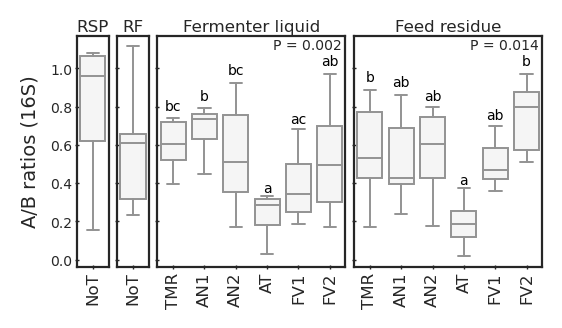

In [80]:
#Archaea/Bacteria 16S plot
meta = META.copy()

#get domains ratio
for dom in DOMS:
    data = tab_unzip(f'{TABS}/{dom}-table.qzv')
    meta[dom] = data.Reads
meta = meta.loc[(meta.Archaea.notna()) & (meta.Bacteria.notna())]
meta['AB_ratios'] = meta['Archaea']/meta['Bacteria']

#declare figure
ratios = [len(META.loc[META.sType==st].Trt.unique()) for st in STYPES] #get wildth ratios
fig, axes = plt.subplots(1, 4, figsize=(3, 1.5), sharey='row',
            gridspec_kw={'wspace': .08, 'width_ratios': ratios})

#iterate through sample-types
for i, st in enumerate(STYPES):
    df = meta.loc[meta.sType == st].copy()
       
    #plot
    ax = axes[i]
    order = [v for v in CDICT if v in df.Trt.unique()]
    sns.boxplot(x='Trt', y='AB_ratios', data=df, linewidth=0.7, showfliers=False, 
                    order=order, color='whitesmoke', ax=ax)
    
    #stats
    if st in ['FL', 'FR']:
        formula= f'AB_ratios ~ Trt + rstc_run'
        anova, pairwise, residuals = run_anova(formula, df)
        anova.to_csv(f'Results/Taxabarplots/{st}_AB-ratios_anova_Trt.tsv', sep='\t')
        pairwise.to_csv(f'Results/Taxabarplots/{st}_AB-ratios_anova_Trt_pairs.tsv', sep='\t')
        residuals.to_csv(f'Results/Taxabarplots/{st}_AB-ratios_anova_Trt_residuals.tsv', sep='\t')
        pairwise = pairwise.loc[~pairwise.index.str.contains('rstc')].copy()
        pairwise['Pair'] = pairwise.index
        pairwise[['Group1', 'Group2']] = pairwise.Pair.str.split('-', expand=True)
        cld = ABCstat(pairwise,'Group1', 'Group2', 'pvalue-fdr_bh')
        p_gen = round(anova.loc['Trt', 'PR(>F)'], 3)
        p = f'P = {p_gen}'
        if p_gen == 0.0:
            p = f'P < 0.001'
        ax.text(.98, .94, p, size=5, transform=ax.transAxes, ha='right')
        if p_gen <= .05:
            for ix, x in enumerate(order):
                y = mpl.cbook.boxplot_stats(df.loc[df.Trt == x]['AB_ratios'])[0]['whishi']
                let = cld.loc[x, 'letters']
                ax.text(ix, y * 1.05, let, size=5, ha='center', color='black')

    #aestheticks
    ax.tick_params(axis='both', labelsize=5, pad=1, length=1.6, width=.5, direction='inout')
    ax.tick_params(axis='x', labelsize=6, rotation=90)
    ax.set_ylabel(f'A/B ratios (16S)', fontsize=7)
    ax.set_xlabel(f'', fontsize=7)
    if st != 'RSP':
        ax.set_ylabel(f'', fontsize=7)
    ax.text(.5, 1.02, STYPES[st], ha='center', fontsize=6, transform=ax.transAxes)
    plt.savefig('Figures/Taxabarplots/AB_ratios.png', bbox_inches='tight', facecolor="w")